# NNDL trainings

## Approach 1

### Common Utility Code

#### Download the kaggle datasets

In [1]:
#Download the dataset from Dropbox
!wget -O released_data.zip "https://www.dropbox.com/s/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip?dl=0"

#Unzip the train, test and other datasets
!unzip -q released_data.zip
!unzip -q ./Released_Data/test_shuffle.zip
!unzip -q ./Released_Data/train_shuffle.zip

--2022-12-18 23:49:08--  https://www.dropbox.com/s/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip [following]
--2022-12-18 23:49:08--  https://www.dropbox.com/s/raw/c2dvapqb613ukhw/Released_Data-20221201T215316Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5cecf31da349937ba31efc0b56.dl.dropboxusercontent.com/cd/0/inline/By5Rs_22qLCoKz5Kh2hMZY11b5vjuNXQL7Y9-UFPJrp6CZdMYP73Zioova06YdvLmLPdqdlB38tzS42w0yoJ_qJcd36rpRrYOCs3LTeTWKeMz3SfZI5cDlEt4KDkvgAoQ5SHX6SHwMdcB41E7nnYGnUtDlW-pBIWamwzUSE5tOPJFA/file# [following]
--2022-12-18 23:49:08--  https://uc5cecf31da349937ba31efc0b56.dl.dropboxusercontent.com/cd/0/inli

#### Display sample images

512.jpg (64, 64, 3)


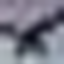

755.jpg (64, 64, 3)


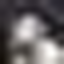

1585.jpg (64, 64, 3)


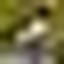

4496.jpg (64, 64, 3)


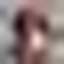

3643.jpg (64, 64, 3)


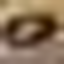

512.jpg (64, 64, 3)


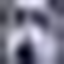

755.jpg (64, 64, 3)


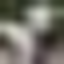

8913.jpg (64, 64, 3)


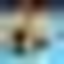

1585.jpg (64, 64, 3)


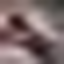

4496.jpg (64, 64, 3)


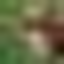

In [2]:
import os
import cv2
from google.colab.patches import cv2_imshow

full_train_imgs = os.listdir("./train_shuffle")
full_test_imgs = os.listdir("./test_shuffle")


for i in range(5):
    train_img = cv2.imread(os.path.join('train_shuffle', full_train_imgs[i]), cv2.IMREAD_UNCHANGED)
    train_img = cv2.resize(train_img, (64, 64), interpolation = cv2.INTER_CUBIC)
    print(full_train_imgs[i], train_img.shape)
    #cv2.imwrite("sample_test.png", test_img)
    cv2_imshow(train_img)


for i in range(5):
    test_img = cv2.imread(os.path.join('test_shuffle', full_test_imgs[i]), cv2.IMREAD_UNCHANGED)
    test_img = cv2.resize(test_img, (64, 64), interpolation = cv2.INTER_CUBIC)
    print(full_test_imgs[i], test_img.shape)
    #cv2.imwrite("sample_test.png", test_img)
    cv2_imshow(test_img)

#### Create new folder with 64x64 images

In [3]:
import os
import cv2

img_names = os.listdir("train_shuffle")
os.makedirs("train_shuffle_64", exist_ok = True)

for img_name in img_names:
    img = cv2.imread(os.path.join("train_shuffle", img_name), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join("train_shuffle_64", img_name), img)

print(len(os.listdir("train_shuffle_64")))

6472


#### Create new folder with 32x32 images

In [4]:
import os
import cv2

img_names = os.listdir("train_shuffle")
os.makedirs("train_shuffle_32", exist_ok = True)

for img_name in img_names:
    img = cv2.imread(os.path.join("train_shuffle", img_name), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join("train_shuffle_32", img_name), img)

print(len(os.listdir("train_shuffle_32")))

6472


#### Get the device

In [5]:
#Always upgrade to the latest versions
#!pip3 install --upgrade torch torchvision

import torch

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


### Load the tensorboard

In [6]:
!pip3 install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#!rm -rf runs
#!rm -rf models
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

### Baseline Dataset and Dataloader preparation

#### Train and Validation Split

In [8]:
import pandas as pd
import numpy as np
full_labels = pd.read_csv('./Released_Data/train_data.csv').to_numpy()

labels_list = [set(),set(),set()]

#prepare lists based on the super classes
labels_list = [{}, {}, {}]
val_labels_list = [{}, {}, {}]

# Create mapping between the sub classes and the super classes
sub_class_list = [{}, {}, {}]

for i in range(len(full_labels)):
    if full_labels[i][2] in labels_list[full_labels[i][1]]:
        labels_list[full_labels[i][1]][full_labels[i][2]] += 1
    else:
        labels_list[full_labels[i][1]][full_labels[i][2]] = 1
        val_labels_list[full_labels[i][1]][full_labels[i][2]] = 0
        sub_class_list[full_labels[i][1]][len(sub_class_list[full_labels[i][1]])] = full_labels[i][2]

# Check the number of times each sub class appears
print(dict(sorted(labels_list[0].items(), key=lambda item: item[1])))
print(dict(sorted(labels_list[1].items(), key=lambda item: item[1])))
print(dict(sorted(labels_list[2].items(), key=lambda item: item[1])))

# print(sub_class_list[0])
# print(sub_class_list[1])
# print(sub_class_list[2])


#Splitting the train and validation datasets
train_imgs = []
val_imgs = []

for i in range(len(full_labels)):
    if val_labels_list[full_labels[i][1]][full_labels[i][2]] <= (0.1)*(labels_list[full_labels[i][1]][full_labels[i][2]]):
        val_labels_list[full_labels[i][1]][full_labels[i][2]] += 1
        val_imgs.append(full_labels[i][0])
    else:
        train_imgs.append(full_labels[i][0])

#Check if there is any common image between training and validation datasets
common_names = [name for name in train_imgs if name in val_imgs]
print("Common names: ", common_names)

train_data = full_labels[np.isin(full_labels[:, 0], train_imgs)]
val_data = full_labels[np.isin(full_labels[:, 0], val_imgs)]

#Check if there is any name missing from the training dataset
ver_train_names = train_data[:, 0]
error_names = [name for name in ver_train_names if name not in train_imgs]
print("Error names: ", error_names)

print("Total number of images: ", len(full_labels))
print("Number of training images: ", train_data.shape)
print("Number of validation images: ", val_data.shape)
# print(type(train_data[0][0]))
# print(type(train_data[0][1]))
# print(type(val_data[0][0]))
# print(type(val_data[0][1]))


# --------Code to check the distribution of super and sub classes in the training and validation datasets---------
train_sub_dict = {}
train_super_dict = {}
val_sub_dict = {}
val_super_dict = {}

for i in range(full_labels.shape[0]):
    name = full_labels[i][0]
    super_class = full_labels[i][1]
    sub_class = full_labels[i][2]

    if name in val_data[:, 0]:
        if super_class in val_super_dict:
            val_super_dict[super_class] += 1
        else:
            val_super_dict[super_class] = 1
        
        if sub_class in val_sub_dict:
            val_sub_dict[sub_class] += 1
        else:
            val_sub_dict[sub_class] = 1
    else:
        if super_class in train_super_dict:
            train_super_dict[super_class] += 1
        else:
            train_super_dict[super_class] = 1
        
        if sub_class in train_sub_dict:
            train_sub_dict[sub_class] += 1
        else:
            train_sub_dict[sub_class] = 1

print("Super Class distribution:")
for k in val_super_dict:
    print("Class: ", k, " Validation: ", val_super_dict[k], " Train: ", train_super_dict[k], " Ratio: ", train_super_dict[k]/val_super_dict[k])

print("------------------------------")
print("Sub Class distribution:")
min_val = 10000
max_val = -1
for k in val_sub_dict:
    min_val = min(min_val, train_sub_dict[k]/val_sub_dict[k])
    max_val = max(max_val, train_sub_dict[k]/val_sub_dict[k])
    print("Class: ", k, " Validation: ", val_sub_dict[k], " Train: ", train_sub_dict[k], " Ratio: ", train_sub_dict[k]/val_sub_dict[k])

print("Minimum Sub Class ratio: ", min_val)
print("Maximum Sub Class ratio: ", max_val)

{74: 51, 11: 51, 14: 51, 5: 51, 41: 51, 16: 51, 85: 51, 52: 51, 40: 51, 57: 51, 79: 51, 82: 51, 42: 51, 88: 51, 8: 51, 26: 51, 20: 51, 60: 51, 61: 51, 81: 51, 84: 51, 19: 51, 24: 100, 30: 100, 27: 100, 6: 100, 28: 100, 76: 100, 86: 100, 4: 100}
{12: 50, 38: 50, 10: 50, 45: 50, 80: 50, 87: 50, 23: 50, 32: 50, 9: 50, 17: 50, 2: 50, 55: 50, 78: 50, 54: 50, 0: 50, 25: 50, 63: 100, 49: 100, 22: 100, 18: 100, 7: 100, 66: 100, 71: 100, 37: 100, 65: 100, 31: 100, 21: 100, 46: 100, 36: 100}
{48: 50, 68: 50, 69: 50, 75: 50, 3: 50, 56: 50, 33: 50, 34: 50, 39: 50, 13: 50, 15: 50, 72: 100, 43: 100, 1: 100, 53: 100, 67: 100, 58: 100, 59: 100, 35: 100, 70: 100, 73: 100, 77: 100, 51: 100, 64: 100, 44: 100, 29: 100, 50: 100, 83: 100, 62: 100, 47: 100}
Common names:  []
Error names:  []
Total number of images:  6472
Number of training images:  (5738, 3)
Number of validation images:  (734, 3)
Super Class distribution:
Class:  1  Validation:  239  Train:  1861  Ratio:  7.7866108786610875
Class:  0  Valida

#### KaggleDataset

In [9]:
import os
import sys
import pandas as pd
import cv2
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KaggleDataset(nn.Module):
    def __init__(self, mode = 'train'):
        super(KaggleDataset, self).__init__()
        self.mode = mode

        if mode == 'train':
            self.dataset = train_data
        else:
            self.dataset = val_data
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx][0]
        img = cv2.imread(os.path.join('train_shuffle_32', img_name))   
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #convert image from BGR to RGB format

        super_class = torch.tensor(self.dataset[idx][1], dtype = torch.float32)
        sub_class = torch.tensor(self.dataset[idx][2], dtype = torch.float32)

        apply_transform = self.transform_data()
        image = apply_transform(image = img)['image']

        return image, super_class, sub_class

    def transform_data(self):

        if self.mode == 'train':
            transform_func = A.Compose(
              [
                  #flip the image 40% of the time
                  A.HorizontalFlip(p=0.4),  
                  #shift, scale and rotate the image 50% of the time
                  A.ShiftScaleRotate(shift_limit=0.025, scale_limit=0, rotate_limit=15, p=0.5),
                  #randomly change brightness, contrast, and saturation of the image 50% of the time
                  A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0, p=0.5), 
                  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1), 
                  ToTensorV2(p=1),
              ])
        else:     #augmentations during validation and testing
          transform_func = A.Compose(
          [   
              A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),
              ToTensorV2(p=1),
          ])
    
        return transform_func

#### KaggleDataloader

In [10]:
from torch.utils.data import DataLoader

train_dataset = KaggleDataset(mode='train')
val_dataset = KaggleDataset(mode='val')
    
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle = False)

# print(len(train_loader))
# print(len(val_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Baseline Model

#### Baseline Super Class model

##### Super Class training utility function

In [ ]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs = model(images)
                        super_loss = loss_func(super_outputs, super_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)

                        loss = 5 * super_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                
                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")   
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the Super Class model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the Swin Transformer model trained on ImageNet
backbone_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
backbone_model.head = nn.Identity()

class BaselineSuperModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 768, out_features = 3)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        return super_class_out

# Create the baseline model
baseline_super_model = BaselineSuperModel(backbone_model)
baseline_super_model = baseline_super_model.to(device, non_blocking = True)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

##### Train the Super Class model

###### Freeze all the layers except Classifier layers (phase 1)

In [ ]:
# Training the model (with all backbone frozen)
for param in baseline_super_model.parameters():
    param.requires_grad = True

for param in baseline_super_model.backbone.parameters():
    param.requires_grad = False

summary(baseline_super_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_super_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 3
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_super_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_frozen'
)

Epoch 0 train: 100%|██████████| 180/180 [00:07<00:00, 23.15batch/s, loss=4.69, super_class_accuracy=0.7]


Epoch 0 train Super Class loss: 4.82147335289413 Super Class acc: 0.5449634194374084


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 32.53batch/s, loss=4.27, super_class_accuracy=0.633]


Epoch 0 val Super Class loss: 4.2532674192732625 Super Class acc: 0.6158037781715393
--------------------


Epoch 1 train: 100%|██████████| 180/180 [00:08<00:00, 22.39batch/s, loss=5.8, super_class_accuracy=0.7]


Epoch 1 train Super Class loss: 4.075293569624653 Super Class acc: 0.6418612599372864


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 23.16batch/s, loss=3.89, super_class_accuracy=0.6]


Epoch 1 val Super Class loss: 3.843906446276309 Super Class acc: 0.6689373254776001
--------------------


Epoch 2 train: 100%|██████████| 180/180 [00:07<00:00, 24.12batch/s, loss=2.43, super_class_accuracy=0.8]


Epoch 2 train Super Class loss: 3.755002365882241 Super Class acc: 0.684384822845459


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 34.05batch/s, loss=3.62, super_class_accuracy=0.667]


Epoch 2 val Super Class loss: 3.625774547579503 Super Class acc: 0.6866484880447388
--------------------
Best Super Class val acc: 0.6866484880447388
Average Time taken for an epoch: 9.483170509338379 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [ ]:
# Training the model (with some backbone frozen)
for param in baseline_super_model.parameters():
    param.requires_grad = True

#print(baseline_model.backbone.features[7])

for param in baseline_super_model.backbone.features[:8].parameters():
    param.requires_grad = False

for idx, (name, param) in enumerate(baseline_super_model.backbone.features[7].named_parameters()):
    #print(name, idx)
    if idx > 15:
        param.requires_grad = True

summary(baseline_super_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_super_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 5
initial_epoch = 3
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_super_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_semi_frozen'
)

Epoch 3 train: 100%|██████████| 180/180 [00:08<00:00, 21.32batch/s, loss=2.76, super_class_accuracy=0.8]


Epoch 3 train Super Class loss: 3.4882886364469132 Super Class acc: 0.7091320753097534


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 34.40batch/s, loss=3.23, super_class_accuracy=0.667]


Epoch 3 val Super Class loss: 3.076882973841166 Super Class acc: 0.7670299410820007
--------------------


Epoch 4 train: 100%|██████████| 180/180 [00:08<00:00, 21.50batch/s, loss=2.73, super_class_accuracy=0.8]


Epoch 4 train Super Class loss: 2.9844414220740463 Super Class acc: 0.7588009834289551


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 33.48batch/s, loss=3.01, super_class_accuracy=0.733]


Epoch 4 val Super Class loss: 2.8612357621621696 Super Class acc: 0.7752043604850769
--------------------


Epoch 5 train: 100%|██████████| 180/180 [00:08<00:00, 21.42batch/s, loss=5.48, super_class_accuracy=0.6]


Epoch 5 train Super Class loss: 2.7144633736831465 Super Class acc: 0.784593939781189


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 32.99batch/s, loss=3.11, super_class_accuracy=0.8]


Epoch 5 val Super Class loss: 2.6942027281025775 Super Class acc: 0.7929155230522156
--------------------


Epoch 6 train: 100%|██████████| 180/180 [00:08<00:00, 21.50batch/s, loss=3.76, super_class_accuracy=0.7]


Epoch 6 train Super Class loss: 2.5245388345088475 Super Class acc: 0.7985360622406006


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 33.03batch/s, loss=2.98, super_class_accuracy=0.7]


Epoch 6 val Super Class loss: 2.657127040121146 Super Class acc: 0.7847411632537842
--------------------


Epoch 7 train: 100%|██████████| 180/180 [00:08<00:00, 21.46batch/s, loss=2.76, super_class_accuracy=0.7]


Epoch 7 train Super Class loss: 2.4286810574360365 Super Class acc: 0.8070756196975708


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 34.52batch/s, loss=3.46, super_class_accuracy=0.767]


Epoch 7 val Super Class loss: 2.822546451390602 Super Class acc: 0.7833787202835083
--------------------
Best Super Class val acc: 0.7929155230522156
Average Time taken for an epoch: 9.241707229614258 sec


###### Unfreeze all the layers in the network (phase 3)

In [ ]:
# Training the model (with everything unfrozen)
for param in baseline_super_model.parameters():
    param.requires_grad = True

summary(baseline_super_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_super_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 10
initial_epoch = 8
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_super_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_unfrozen'
)

Epoch 8 train: 100%|██████████| 180/180 [00:16<00:00, 10.77batch/s, loss=2.29, super_class_accuracy=0.8]


Epoch 8 train Super Class loss: 3.0272700613427554 Super Class acc: 0.7636806964874268


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 31.54batch/s, loss=2.35, super_class_accuracy=0.833]


Epoch 8 val Super Class loss: 2.365348228641687 Super Class acc: 0.829700231552124
--------------------


Epoch 9 train: 100%|██████████| 180/180 [00:15<00:00, 11.63batch/s, loss=2.82, super_class_accuracy=0.8]


Epoch 9 train Super Class loss: 2.2728976892984547 Super Class acc: 0.8271174430847168


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 33.10batch/s, loss=1.29, super_class_accuracy=0.933]


Epoch 9 val Super Class loss: 2.2612869816677446 Super Class acc: 0.8201634883880615
--------------------


Epoch 10 train: 100%|██████████| 180/180 [00:15<00:00, 11.92batch/s, loss=1.67, super_class_accuracy=0.9]


Epoch 10 train Super Class loss: 1.9374616775478624 Super Class acc: 0.8539560437202454


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 32.88batch/s, loss=1.71, super_class_accuracy=0.867]


Epoch 10 val Super Class loss: 2.440904890483991 Super Class acc: 0.8106266856193542
--------------------


Epoch 11 train: 100%|██████████| 180/180 [00:15<00:00, 11.33batch/s, loss=2.35, super_class_accuracy=0.9]


Epoch 11 train Super Class loss: 1.723081583073431 Super Class acc: 0.8713837265968323


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 31.98batch/s, loss=1.78, super_class_accuracy=0.833]


Epoch 11 val Super Class loss: 1.9964888488889065 Super Class acc: 0.8446866273880005
--------------------


Epoch 12 train: 100%|██████████| 180/180 [00:16<00:00, 10.73batch/s, loss=0.594, super_class_accuracy=1]


Epoch 12 train Super Class loss: 1.4912948884140036 Super Class acc: 0.8915998339653015


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 31.85batch/s, loss=1.13, super_class_accuracy=0.933]


Epoch 12 val Super Class loss: 1.9191545258182272 Super Class acc: 0.8514986038208008
--------------------


Epoch 13 train: 100%|██████████| 180/180 [00:15<00:00, 11.67batch/s, loss=0.686, super_class_accuracy=1]


Epoch 13 train Super Class loss: 1.3280023047528478 Super Class acc: 0.9004879593849182


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 31.13batch/s, loss=1.41, super_class_accuracy=0.9]


Epoch 13 val Super Class loss: 2.139566760784274 Super Class acc: 0.8365122675895691
--------------------


Epoch 14 train: 100%|██████████| 180/180 [00:15<00:00, 11.85batch/s, loss=1.15, super_class_accuracy=1]


Epoch 14 train Super Class loss: 1.2349051365654158 Super Class acc: 0.9097246527671814


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 32.54batch/s, loss=0.455, super_class_accuracy=0.967]


Epoch 14 val Super Class loss: 2.2193308215212757 Super Class acc: 0.8460490107536316
--------------------


Epoch 15 train: 100%|██████████| 180/180 [00:15<00:00, 11.59batch/s, loss=2.38, super_class_accuracy=0.8]


Epoch 15 train Super Class loss: 1.1453671865074342 Super Class acc: 0.911990225315094


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 30.28batch/s, loss=0.845, super_class_accuracy=0.933]


Epoch 15 val Super Class loss: 2.1664185087102634 Super Class acc: 0.85694819688797
--------------------


Epoch 16 train: 100%|██████████| 180/180 [00:15<00:00, 11.73batch/s, loss=0.869, super_class_accuracy=0.9]


Epoch 16 train Super Class loss: 0.9638863001583594 Super Class acc: 0.9278494119644165


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 31.52batch/s, loss=0.737, super_class_accuracy=0.933]


Epoch 16 val Super Class loss: 2.0981600492867853 Super Class acc: 0.863760232925415
--------------------


Epoch 17 train: 100%|██████████| 180/180 [00:15<00:00, 11.76batch/s, loss=0.312, super_class_accuracy=1]


Epoch 17 train Super Class loss: 0.8243874848893957 Super Class acc: 0.9414430260658264


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 31.10batch/s, loss=1.78, super_class_accuracy=0.9]

Epoch 17 val Super Class loss: 2.317374534194411 Super Class acc: 0.8528610467910767
--------------------
Best Super Class val acc: 0.863760232925415
Average Time taken for an epoch: 16.542545127868653 sec


#### Baseline Sub Class model

##### Sub Class training utility function

In [ ]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the sub class validation accuracies
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_sub_loss = 0.
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        sub_outputs = model(images)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")
                
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")   
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the Sub Class model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the Swin Transformer model trained on ImageNet
backbone_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
backbone_model.head = nn.Identity()

# input = torch.rand((1, 3, 32, 32))
# output = backbone_model(input)
# print(output.shape)

class BaselineSubModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 768, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        sub_class_out = self.subclass(out)
        return sub_class_out

# Create the baseline model
baseline_sub_model = BaselineSubModel(backbone_model)
baseline_sub_model = baseline_sub_model.to(device, non_blocking = True)

##### Train the Sub Class model

###### Freeze all the layers except Classifier layers (phase 1)

In [ ]:
# Training the model (with all backbone frozen)
for param in baseline_sub_model.parameters():
    param.requires_grad = True

for param in baseline_sub_model.backbone.parameters():
    param.requires_grad = False

summary(baseline_sub_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_sub_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_sub_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_frozen'
)

Epoch 0 train: 100%|██████████| 180/180 [00:07<00:00, 24.35batch/s, loss=9.47, sub_class_accuracy=0]


Epoch 0 train Sub Class loss: 9.045067670163315 Sub Class acc: 0.029801324009895325


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 34.65batch/s, loss=8.83, sub_class_accuracy=0.0333]


Epoch 0 val Sub Class loss: 8.577811056651601 Sub Class acc: 0.06403269618749619
--------------------


Epoch 1 train: 100%|██████████| 180/180 [00:07<00:00, 24.08batch/s, loss=8.79, sub_class_accuracy=0]


Epoch 1 train Sub Class loss: 8.3459862708713 Sub Class acc: 0.07145346701145172


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 32.03batch/s, loss=8.59, sub_class_accuracy=0.0667]


Epoch 1 val Sub Class loss: 8.125049461136072 Sub Class acc: 0.10490462929010391
--------------------


Epoch 2 train: 100%|██████████| 180/180 [00:07<00:00, 24.17batch/s, loss=7.69, sub_class_accuracy=0.1]


Epoch 2 train Sub Class loss: 7.931267695129437 Sub Class acc: 0.11293133348226547


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 34.53batch/s, loss=8.44, sub_class_accuracy=0.0333]


Epoch 2 val Sub Class loss: 7.815843569160482 Sub Class acc: 0.12261579930782318
--------------------


Epoch 3 train: 100%|██████████| 180/180 [00:08<00:00, 20.74batch/s, loss=7.78, sub_class_accuracy=0.1]


Epoch 3 train Sub Class loss: 7.555991061268139 Sub Class acc: 0.14360404014587402


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 33.47batch/s, loss=8.43, sub_class_accuracy=0]


Epoch 3 val Sub Class loss: 7.585698720219999 Sub Class acc: 0.13760218024253845
--------------------


Epoch 4 train: 100%|██████████| 180/180 [00:07<00:00, 24.12batch/s, loss=7.7, sub_class_accuracy=0.1]


Epoch 4 train Sub Class loss: 7.304360453531525 Sub Class acc: 0.1624259352684021


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 31.17batch/s, loss=8.31, sub_class_accuracy=0.0333]


Epoch 4 val Sub Class loss: 7.410756386593187 Sub Class acc: 0.14032697677612305
--------------------
Best Sub Class val acc: 0.14032697677612305
Average Time taken for an epoch: 8.645339488983154 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [ ]:
# Training the model (with some backbone frozen)
for param in baseline_sub_model.parameters():
    param.requires_grad = True

for param in baseline_sub_model.backbone.features[:8].parameters():
    param.requires_grad = False

for idx, (name, param) in enumerate(baseline_sub_model.backbone.features[7].named_parameters()):
    #print(name, idx)
    if idx > 15:
        param.requires_grad = True

summary(baseline_sub_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_sub_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 5
initial_epoch = 5
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_sub_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_semi_frozen'
)

Epoch 5 train: 100%|██████████| 180/180 [00:08<00:00, 21.03batch/s, loss=5.53, sub_class_accuracy=0.4]


Epoch 5 train Sub Class loss: 6.950139871413136 Sub Class acc: 0.17148831486701965


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 34.53batch/s, loss=8.4, sub_class_accuracy=0.0333]


Epoch 5 val Sub Class loss: 6.824393636199369 Sub Class acc: 0.17711171507835388
--------------------


Epoch 6 train: 100%|██████████| 180/180 [00:08<00:00, 21.19batch/s, loss=7.59, sub_class_accuracy=0]


Epoch 6 train Sub Class loss: 6.034075055566138 Sub Class acc: 0.2476472556591034


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 30.91batch/s, loss=8.16, sub_class_accuracy=0.0667]


Epoch 6 val Sub Class loss: 6.667068218989983 Sub Class acc: 0.18528610467910767
--------------------


Epoch 7 train: 100%|██████████| 180/180 [00:08<00:00, 20.56batch/s, loss=5.79, sub_class_accuracy=0.2]


Epoch 7 train Sub Class loss: 5.346681682936362 Sub Class acc: 0.32154059410095215


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 30.99batch/s, loss=8.57, sub_class_accuracy=0.0333]


Epoch 7 val Sub Class loss: 6.762468301632748 Sub Class acc: 0.19073569774627686
--------------------


Epoch 8 train: 100%|██████████| 180/180 [00:08<00:00, 20.51batch/s, loss=5.74, sub_class_accuracy=0.2]


Epoch 8 train Sub Class loss: 4.707395521345434 Sub Class acc: 0.38062041997909546


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 33.65batch/s, loss=9.15, sub_class_accuracy=0.0333]


Epoch 8 val Sub Class loss: 7.032096171573982 Sub Class acc: 0.18119890987873077
--------------------


Epoch 9 train: 100%|██████████| 180/180 [00:08<00:00, 21.40batch/s, loss=3.61, sub_class_accuracy=0.5]


Epoch 9 train Sub Class loss: 4.228890012306966 Sub Class acc: 0.4390031397342682


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 31.82batch/s, loss=9.34, sub_class_accuracy=0.0333]


Epoch 9 val Sub Class loss: 7.232087569275734 Sub Class acc: 0.19754767417907715
--------------------
Best Sub Class val acc: 0.19754767417907715
Average Time taken for an epoch: 9.522721242904662 sec


###### Unfreeze all the layers in the network (phase 3)

In [ ]:
# Training the model (with everything unfrozen)
for param in baseline_sub_model.parameters():
    param.requires_grad = True

summary(baseline_sub_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_sub_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 10
initial_epoch = 10
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_sub_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_SwinT_unfrozen'
)

Epoch 10 train: 100%|██████████| 180/180 [00:15<00:00, 11.94batch/s, loss=6.81, sub_class_accuracy=0.1]


Epoch 10 train Sub Class loss: 5.662336003119707 Sub Class acc: 0.26368072628974915


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 33.00batch/s, loss=6.62, sub_class_accuracy=0.167]


Epoch 10 val Sub Class loss: 6.1117013338801 Sub Class acc: 0.20572206377983093
--------------------


Epoch 11 train: 100%|██████████| 180/180 [00:15<00:00, 11.72batch/s, loss=4.99, sub_class_accuracy=0.3]


Epoch 11 train Sub Class loss: 4.613216345798017 Sub Class acc: 0.3708609342575073


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 32.02batch/s, loss=6.75, sub_class_accuracy=0.167]


Epoch 11 val Sub Class loss: 5.982834123460734 Sub Class acc: 0.24386920034885406
--------------------


Epoch 12 train: 100%|██████████| 180/180 [00:15<00:00, 11.53batch/s, loss=3.78, sub_class_accuracy=0.5]


Epoch 12 train Sub Class loss: 3.9517699715649885 Sub Class acc: 0.4428372085094452


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 31.55batch/s, loss=6.67, sub_class_accuracy=0.167]


Epoch 12 val Sub Class loss: 6.0940348926616945 Sub Class acc: 0.24386920034885406
--------------------


Epoch 13 train: 100%|██████████| 180/180 [00:16<00:00, 10.94batch/s, loss=4.59, sub_class_accuracy=0.4]


Epoch 13 train Sub Class loss: 3.2953145438347513 Sub Class acc: 0.5231788158416748


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 32.06batch/s, loss=7.76, sub_class_accuracy=0.1]


Epoch 13 val Sub Class loss: 6.214816128525487 Sub Class acc: 0.25476840138435364
--------------------


Epoch 14 train: 100%|██████████| 180/180 [00:15<00:00, 11.74batch/s, loss=4.75, sub_class_accuracy=0.4]


Epoch 14 train Sub Class loss: 2.7633775735657653 Sub Class acc: 0.5930637717247009


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 32.21batch/s, loss=7.35, sub_class_accuracy=0.267]


Epoch 14 val Sub Class loss: 6.246788479651677 Sub Class acc: 0.2643051743507385
--------------------


Epoch 15 train: 100%|██████████| 180/180 [00:15<00:00, 11.72batch/s, loss=2.07, sub_class_accuracy=0.7]


Epoch 15 train Sub Class loss: 2.244989477246013 Sub Class acc: 0.6707912087440491


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 31.62batch/s, loss=7.69, sub_class_accuracy=0.267]


Epoch 15 val Sub Class loss: 6.846289690573793 Sub Class acc: 0.2806539535522461
--------------------


Epoch 16 train: 100%|██████████| 180/180 [00:15<00:00, 11.50batch/s, loss=1.32, sub_class_accuracy=0.7]


Epoch 16 train Sub Class loss: 1.9519951399629978 Sub Class acc: 0.707563579082489


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 32.68batch/s, loss=8.96, sub_class_accuracy=0.2]


Epoch 16 val Sub Class loss: 7.678999864437924 Sub Class acc: 0.23433242738246918
--------------------


Epoch 17 train: 100%|██████████| 180/180 [00:15<00:00, 11.71batch/s, loss=1.27, sub_class_accuracy=0.8]


Epoch 17 train Sub Class loss: 1.7411795473963012 Sub Class acc: 0.7295224666595459


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 31.28batch/s, loss=8.15, sub_class_accuracy=0.2]


Epoch 17 val Sub Class loss: 7.421948944840184 Sub Class acc: 0.24795639514923096
--------------------


Epoch 18 train: 100%|██████████| 180/180 [00:15<00:00, 11.54batch/s, loss=0.132, sub_class_accuracy=1]


Epoch 18 train Sub Class loss: 1.3825934658475603 Sub Class acc: 0.7908678650856018


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 31.82batch/s, loss=8.69, sub_class_accuracy=0.233]


Epoch 18 val Sub Class loss: 8.049755163998306 Sub Class acc: 0.25068119168281555
--------------------


Epoch 19 train: 100%|██████████| 180/180 [00:15<00:00, 11.51batch/s, loss=2.4, sub_class_accuracy=0.6]


Epoch 19 train Sub Class loss: 1.2546675747053346 Sub Class acc: 0.8098640441894531


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 31.00batch/s, loss=9.26, sub_class_accuracy=0.333]

Epoch 19 val Sub Class loss: 8.47159391398001 Sub Class acc: 0.25476840138435364
--------------------
Best Sub Class val acc: 0.2806539535522461
Average Time taken for an epoch: 16.404507565498353 sec


### Baseline Joint Super Sub Class Model

##### Joint training utility function

In [11]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs, sub_outputs = model(images)

                        super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 5 * super_loss + 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                print(f"Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")

                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the Joint model

In [19]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the Swin Transformer model trained on ImageNet
backbone_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
backbone_model.head = nn.Identity()

class BaselineModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes and 89 sub classes
        self.superclass = nn.Linear(in_features = 768, out_features = 3)
        self.subclass = nn.Linear(in_features = 768, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
baseline_model = BaselineModel(backbone_model)
baseline_model = baseline_model.to(device, non_blocking = True)

##### Train the Joint model

###### Freeze all the layers except Classifier layers (phase 1)

In [20]:
# Training the model (with all backbone frozen)
for param in baseline_model.parameters():
    param.requires_grad = True

for param in baseline_model.backbone.parameters():
    param.requires_grad = False

summary(baseline_model, (3, 64, 64))

# Check number of parameters
pytorch_total_params = sum(p.numel() for p in baseline_model.parameters())
print(pytorch_total_params)

trainable_params = []

for name, param in baseline_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [21]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_Joint_SwinT_frozen'
)

Epoch 0 train: 100%|██████████| 180/180 [00:08<00:00, 20.50batch/s, loss=13, sub_class_accuracy=0, super_class_accuracy=0.5]


Epoch 0 train Super Class loss: 5.328964847187083 Super Class acc: 0.4726385474205017
Sub Class loss: 9.036592568616578 Sub Class acc: 0.029452770948410034


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 28.04batch/s, loss=13.5, sub_class_accuracy=0.0333, super_class_accuracy=0.5]


Epoch 0 val Super Class loss: 4.462522807498069 Super Class acc: 0.5762942433357239
Sub Class loss: 8.532650825438123 Sub Class acc: 0.06811989098787308
--------------------


Epoch 1 train: 100%|██████████| 180/180 [00:08<00:00, 20.85batch/s, loss=11.9, sub_class_accuracy=0, super_class_accuracy=0.5]


Epoch 1 train Super Class loss: 4.253886572759548 Super Class acc: 0.6214708685874939
Sub Class loss: 8.33917418852547 Sub Class acc: 0.07790170609951019


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 30.00batch/s, loss=12.8, sub_class_accuracy=0.0333, super_class_accuracy=0.6]


Epoch 1 val Super Class loss: 3.9085906419182344 Super Class acc: 0.6594005227088928
Sub Class loss: 8.069492178976699 Sub Class acc: 0.09809264540672302
--------------------


Epoch 2 train: 100%|██████████| 180/180 [00:09<00:00, 18.33batch/s, loss=11.1, sub_class_accuracy=0, super_class_accuracy=0.7]


Epoch 2 train Super Class loss: 3.8419159487507906 Super Class acc: 0.6760194897651672
Sub Class loss: 7.90146464144739 Sub Class acc: 0.11258278042078018


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 28.80batch/s, loss=12.5, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 2 val Super Class loss: 3.64877019737332 Super Class acc: 0.6880108714103699
Sub Class loss: 7.7642061301083265 Sub Class acc: 0.12534059584140778
--------------------


Epoch 3 train: 100%|██████████| 180/180 [00:08<00:00, 21.05batch/s, loss=11, sub_class_accuracy=0.1, super_class_accuracy=0.9]


Epoch 3 train Super Class loss: 3.62490751864645 Super Class acc: 0.6950156688690186
Sub Class loss: 7.514234652540832 Sub Class acc: 0.14203554391860962


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 28.96batch/s, loss=12.3, sub_class_accuracy=0.0333, super_class_accuracy=0.667]


Epoch 3 val Super Class loss: 3.468185738744138 Super Class acc: 0.7057220339775085
Sub Class loss: 7.535686916486444 Sub Class acc: 0.13351498544216156
--------------------


Epoch 4 train: 100%|██████████| 180/180 [00:08<00:00, 21.37batch/s, loss=10.8, sub_class_accuracy=0.1, super_class_accuracy=0.8]


Epoch 4 train Super Class loss: 3.4910838097676704 Super Class acc: 0.719240128993988
Sub Class loss: 7.26467843153785 Sub Class acc: 0.1646915227174759


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 30.01batch/s, loss=12.2, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 4 val Super Class loss: 3.3744200406347375 Super Class acc: 0.7193460464477539
Sub Class loss: 7.366533035153589 Sub Class acc: 0.13487738370895386
--------------------
Best Super Class val acc: 0.7193460464477539
Best Sub Class val acc: 0.13487738370895386
Average Time taken for an epoch: 10.185715055465698 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [22]:
# Training the model (with some backbone frozen)
for param in baseline_model.parameters():
    param.requires_grad = True

for param in baseline_model.backbone.features[:8].parameters():
    param.requires_grad = False

for idx, (name, param) in enumerate(baseline_model.backbone.features[7].named_parameters()):
    #print(name, idx)
    if idx > 15:
        param.requires_grad = True

summary(baseline_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [23]:
epochs = 6
initial_epoch = 5
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_Joint_SwinT_semi_frozen'
)

Epoch 5 train: 100%|██████████| 180/180 [00:09<00:00, 18.95batch/s, loss=6.58, sub_class_accuracy=0.4, super_class_accuracy=0.9]


Epoch 5 train Super Class loss: 3.3434295273587527 Super Class acc: 0.727605402469635
Sub Class loss: 6.895415291299218 Sub Class acc: 0.1751481294631958


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 29.31batch/s, loss=10.9, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 5 val Super Class loss: 2.91723047598831 Super Class acc: 0.7629427909851074
Sub Class loss: 6.869902491244698 Sub Class acc: 0.1689373254776001
--------------------


Epoch 6 train: 100%|██████████| 180/180 [00:09<00:00, 19.98batch/s, loss=14.6, sub_class_accuracy=0.3, super_class_accuracy=0.4]


Epoch 6 train Super Class loss: 2.9602571427510482 Super Class acc: 0.763332188129425
Sub Class loss: 6.1732687466482785 Sub Class acc: 0.23893342912197113


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 30.53batch/s, loss=11.8, sub_class_accuracy=0.0667, super_class_accuracy=0.7]


Epoch 6 val Super Class loss: 2.808729399614828 Super Class acc: 0.7806539535522461
Sub Class loss: 6.623563774275195 Sub Class acc: 0.18801090121269226
--------------------


Epoch 7 train: 100%|██████████| 180/180 [00:09<00:00, 18.16batch/s, loss=9.75, sub_class_accuracy=0.4, super_class_accuracy=0.8]


Epoch 7 train Super Class loss: 2.770463666482934 Super Class acc: 0.7791913151741028
Sub Class loss: 5.625134327138247 Sub Class acc: 0.28494247794151306


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 28.18batch/s, loss=10.9, sub_class_accuracy=0.0333, super_class_accuracy=0.8]


Epoch 7 val Super Class loss: 2.97183755632967 Super Class acc: 0.7806539535522461
Sub Class loss: 6.515550616001888 Sub Class acc: 0.19891007244586945
--------------------


Epoch 8 train: 100%|██████████| 180/180 [00:10<00:00, 17.75batch/s, loss=7.65, sub_class_accuracy=0.2, super_class_accuracy=0.8]


Epoch 8 train Super Class loss: 2.557134427553521 Super Class acc: 0.8006274104118347
Sub Class loss: 5.189878377319421 Sub Class acc: 0.32624608278274536


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 28.30batch/s, loss=11.7, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 8 val Super Class loss: 2.955287161412616 Super Class acc: 0.7956402897834778
Sub Class loss: 6.616044145838766 Sub Class acc: 0.19754767417907715
--------------------


Epoch 9 train: 100%|██████████| 180/180 [00:09<00:00, 19.40batch/s, loss=7.88, sub_class_accuracy=0.1, super_class_accuracy=0.7]


Epoch 9 train Super Class loss: 2.458311077109942 Super Class acc: 0.811781108379364
Sub Class loss: 4.80726651191379 Sub Class acc: 0.376437783241272


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 31.37batch/s, loss=10.4, sub_class_accuracy=0.0333, super_class_accuracy=0.833]


Epoch 9 val Super Class loss: 2.968092195750582 Super Class acc: 0.7806539535522461
Sub Class loss: 6.6192652652958754 Sub Class acc: 0.19073569774627686
--------------------


Epoch 10 train: 100%|██████████| 180/180 [00:09<00:00, 19.86batch/s, loss=5.32, sub_class_accuracy=0.2, super_class_accuracy=1]


Epoch 10 train Super Class loss: 2.20613604131664 Super Class acc: 0.8264203667640686
Sub Class loss: 4.415617847575589 Sub Class acc: 0.41338443756103516


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 29.67batch/s, loss=11.3, sub_class_accuracy=0.0667, super_class_accuracy=0.7]

Epoch 10 val Super Class loss: 3.020709701877199 Super Class acc: 0.776566743850708
Sub Class loss: 6.720046248682838 Sub Class acc: 0.18664850294589996
--------------------
Best Super Class val acc: 0.7956402897834778
Best Sub Class val acc: 0.19891007244586945
Average Time taken for an epoch: 10.56770900885264 sec


###### Unfreeze all the layers in the network (phase 3)

In [24]:
# Training the model (with everything unfrozen)
for param in baseline_model.parameters():
    param.requires_grad = True

summary(baseline_model, (3, 64, 64))

trainable_params = []

for name, param in baseline_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [25]:
epochs = 12
initial_epoch = 11
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    baseline_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Baseline_Joint_SwinT_unfrozen'
)

Epoch 11 train: 100%|██████████| 180/180 [00:17<00:00, 10.46batch/s, loss=9.01, sub_class_accuracy=0, super_class_accuracy=0.7]


Epoch 11 train Super Class loss: 2.834274049376976 Super Class acc: 0.7786685228347778
Sub Class loss: 6.040963886755607 Sub Class acc: 0.22586266696453094


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 29.07batch/s, loss=9.3, sub_class_accuracy=0.0333, super_class_accuracy=0.867]


Epoch 11 val Super Class loss: 2.601215904350177 Super Class acc: 0.7901906967163086
Sub Class loss: 6.093281213204283 Sub Class acc: 0.21253405511379242
--------------------


Epoch 12 train: 100%|██████████| 180/180 [00:17<00:00, 10.39batch/s, loss=4.79, sub_class_accuracy=0.5, super_class_accuracy=1]


Epoch 12 train Super Class loss: 2.1260942441322697 Super Class acc: 0.8398396372795105
Sub Class loss: 5.249378168113392 Sub Class acc: 0.29644474387168884


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 28.55batch/s, loss=7.42, sub_class_accuracy=0.133, super_class_accuracy=0.933]


Epoch 12 val Super Class loss: 1.8738608090689137 Super Class acc: 0.859673023223877
Sub Class loss: 5.702678091844356 Sub Class acc: 0.24114440381526947
--------------------


Epoch 13 train: 100%|██████████| 180/180 [00:18<00:00,  9.80batch/s, loss=5.63, sub_class_accuracy=0.5, super_class_accuracy=0.9]


Epoch 13 train Super Class loss: 1.7497503183036782 Super Class acc: 0.8661554455757141
Sub Class loss: 4.660722582628603 Sub Class acc: 0.3579644560813904


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 28.94batch/s, loss=9.22, sub_class_accuracy=0.167, super_class_accuracy=0.733]


Epoch 13 val Super Class loss: 2.2679681523781707 Super Class acc: 0.8365122675895691
Sub Class loss: 5.797773960175891 Sub Class acc: 0.23024523258209229
--------------------


Epoch 14 train: 100%|██████████| 180/180 [00:17<00:00, 10.35batch/s, loss=7.15, sub_class_accuracy=0.1, super_class_accuracy=0.9]


Epoch 14 train Super Class loss: 1.4427884901575445 Super Class acc: 0.891251266002655
Sub Class loss: 4.167213091745572 Sub Class acc: 0.39909374713897705


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 27.93batch/s, loss=8.64, sub_class_accuracy=0.167, super_class_accuracy=0.833]


Epoch 14 val Super Class loss: 2.1227439470609464 Super Class acc: 0.8365122675895691
Sub Class loss: 5.696847876670899 Sub Class acc: 0.25749319791793823
--------------------


Epoch 15 train: 100%|██████████| 180/180 [00:17<00:00, 10.48batch/s, loss=3.75, sub_class_accuracy=0.5, super_class_accuracy=0.9]


Epoch 15 train Super Class loss: 1.2665798454313337 Super Class acc: 0.9060648083686829
Sub Class loss: 3.81296347026087 Sub Class acc: 0.43917739391326904


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 31.28batch/s, loss=7.85, sub_class_accuracy=0.267, super_class_accuracy=0.9]


Epoch 15 val Super Class loss: 2.1501453233025054 Super Class acc: 0.8501362204551697
Sub Class loss: 5.95773287625014 Sub Class acc: 0.25885558128356934
--------------------


Epoch 16 train: 100%|██████████| 180/180 [00:16<00:00, 11.11batch/s, loss=6.86, sub_class_accuracy=0.4, super_class_accuracy=0.9]


Epoch 16 train Super Class loss: 1.0474347083482978 Super Class acc: 0.9205297827720642
Sub Class loss: 3.368991556795851 Sub Class acc: 0.49128615856170654


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 29.25batch/s, loss=7.88, sub_class_accuracy=0.267, super_class_accuracy=0.9]


Epoch 16 val Super Class loss: 2.6425620166417363 Super Class acc: 0.8419618606567383
Sub Class loss: 6.239957571679305 Sub Class acc: 0.2888283431529999
--------------------


Epoch 17 train: 100%|██████████| 180/180 [00:16<00:00, 10.63batch/s, loss=3.1, sub_class_accuracy=0.4, super_class_accuracy=1]


Epoch 17 train Super Class loss: 0.9606047995121024 Super Class acc: 0.9292436242103577
Sub Class loss: 3.08758310891062 Sub Class acc: 0.5390380024909973


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 27.77batch/s, loss=9.02, sub_class_accuracy=0.133, super_class_accuracy=0.933]


Epoch 17 val Super Class loss: 2.330903110452179 Super Class acc: 0.8514986038208008
Sub Class loss: 6.234845160138704 Sub Class acc: 0.25885558128356934
--------------------


Epoch 18 train: 100%|██████████| 180/180 [00:16<00:00, 10.79batch/s, loss=5.25, sub_class_accuracy=0.4, super_class_accuracy=0.9]


Epoch 18 train Super Class loss: 0.8057861868649171 Super Class acc: 0.9384803175926208
Sub Class loss: 2.785620877783487 Sub Class acc: 0.5698849558830261


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 30.53batch/s, loss=9.56, sub_class_accuracy=0.333, super_class_accuracy=0.9]


Epoch 18 val Super Class loss: 2.2540313127255245 Super Class acc: 0.8610354065895081
Sub Class loss: 6.207986328842205 Sub Class acc: 0.26294276118278503
--------------------


Epoch 19 train: 100%|██████████| 180/180 [00:16<00:00, 11.17batch/s, loss=2.14, sub_class_accuracy=0.8, super_class_accuracy=0.9]


Epoch 19 train Super Class loss: 0.6989779344893948 Super Class acc: 0.9491111636161804
Sub Class loss: 2.4844378452759748 Sub Class acc: 0.6146740913391113


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 32.00batch/s, loss=9.06, sub_class_accuracy=0.267, super_class_accuracy=0.833]


Epoch 19 val Super Class loss: 2.3904783638036866 Super Class acc: 0.8623977899551392
Sub Class loss: 6.5567423810101335 Sub Class acc: 0.26566755771636963
--------------------


Epoch 20 train: 100%|██████████| 180/180 [00:16<00:00, 10.96batch/s, loss=2.78, sub_class_accuracy=0.7, super_class_accuracy=0.9]


Epoch 20 train Super Class loss: 0.6209772618006397 Super Class acc: 0.955907940864563
Sub Class loss: 2.2234037394887607 Sub Class acc: 0.6610317230224609


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 30.38batch/s, loss=9.91, sub_class_accuracy=0.167, super_class_accuracy=0.867]


Epoch 20 val Super Class loss: 2.3245637947109805 Super Class acc: 0.8692098259925842
Sub Class loss: 6.543633211536044 Sub Class acc: 0.25749319791793823
--------------------


Epoch 21 train: 100%|██████████| 180/180 [00:18<00:00,  9.86batch/s, loss=2.52, sub_class_accuracy=0.7, super_class_accuracy=0.9]


Epoch 21 train Super Class loss: 0.666134306643536 Super Class acc: 0.9508539438247681
Sub Class loss: 2.0486428236537546 Sub Class acc: 0.6821191906929016


Epoch 21 val: 100%|██████████| 23/23 [00:00<00:00, 28.84batch/s, loss=9.66, sub_class_accuracy=0.233, super_class_accuracy=0.9]


Epoch 21 val Super Class loss: 2.174131553569347 Super Class acc: 0.8719345927238464
Sub Class loss: 6.656365100954144 Sub Class acc: 0.25340598821640015
--------------------


Epoch 22 train: 100%|██████████| 180/180 [00:16<00:00, 10.62batch/s, loss=2.03, sub_class_accuracy=0.7, super_class_accuracy=1]


Epoch 22 train Super Class loss: 0.47778729074019466 Super Class acc: 0.9658417701721191
Sub Class loss: 1.7466034967336725 Sub Class acc: 0.7227256894111633


Epoch 22 val: 100%|██████████| 23/23 [00:00<00:00, 29.69batch/s, loss=10.9, sub_class_accuracy=0.3, super_class_accuracy=0.867]

Epoch 22 val Super Class loss: 2.9451977301196117 Super Class acc: 0.8446866273880005
Sub Class loss: 7.255734885421046 Sub Class acc: 0.25749319791793823
--------------------
Best Super Class val acc: 0.8719345927238464
Best Sub Class val acc: 0.2888283431529999
Average Time taken for an epoch: 18.133280515670776 sec


### Create Augmented Training Dataset

In [11]:
import os
import sys
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
import albumentations as A

!rm -rf aug_train_shuffle_32
!rm -rf aug_train_shuffle_64

size_val = 64

# Applying augmentations to the image
os.makedirs(f"aug_train_shuffle_{size_val}", exist_ok = True)

aug_train_data = np.array([["", -1, -1]], dtype=object)

for idx in range(len(train_data)):
    file = train_data[idx][0]
    superclass = train_data[idx][1]
    subclass = train_data[idx][2]

    img = cv2.imread(os.path.join(f"train_shuffle_{size_val}", file), cv2.IMREAD_UNCHANGED)
    cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", file), img)

    hflip_transform = A.Compose([A.HorizontalFlip(p = 1)])
    hflip_img = hflip_transform(image = img)['image']
    #cv2_imshow(hflip_img)
    cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"hflip_{file}"), hflip_img)
    aug_train_data = np.vstack((aug_train_data, np.asarray([f"hflip_{file}", superclass, subclass], object)))

    coarse_transform = A.Compose([A.CoarseDropout(max_holes=8, max_height=4, max_width=4, min_holes=8, min_height=4, min_width=4, p=1)])
    coarse_img = coarse_transform(image = img)['image']
    #cv2_imshow(coarse_img)
    cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"coarse_{file}"), coarse_img)
    aug_train_data = np.vstack((aug_train_data, np.asarray([f"coarse_{file}", superclass, subclass], object)))

    
    # Use some more augmentations for lower numbered subclasses
    if labels_list[superclass][subclass] < 55:

        rot_transform = A.Compose([A.Rotate(limit=(90, 90), interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, p=1)])
        rot_img = rot_transform(image = img)['image']
        #cv2_imshow(rot_img)
        cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"rot_{file}"), rot_img)
        aug_train_data = np.vstack((aug_train_data, np.asarray([f"rot_{file}", superclass, subclass], object)))

        trans_transform = A.Compose([A.Affine(translate_percent = (0.05, 0.08), p=1)]) 
        trans_img = trans_transform(image = img)['image']
        #cv2_imshow(trans_img)
        cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"trans_{file}"), trans_img)
        aug_train_data = np.vstack((aug_train_data, np.asarray([f"trans_{file}", superclass, subclass], object)))
    

    # Other Augmentations that we experimented with but didn't give good results
    # vflip_transform = A.Compose([A.VerticalFlip(p = 1)])
    # vflip_img = vflip_transform(image = img)['image']
    # cv2_imshow(vflip_img)
    # cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"vflip_{file}"), vflip_img)
    # aug_train_data = np.vstack((aug_train_data, np.asarray([f"vflip_{file}", superclass, subclass], object)))

    # opt_transform = A.Compose([A.OpticalDistortion(distort_limit=(0.39, 0.40), shift_limit=0.01, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, p=1)])
    # opt_img = opt_transform(image = img)['image']
    # #cv2_imshow(opt_img)
    # cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"opt_{file}"), opt_img)
    # aug_train_data = np.vstack((aug_train_data, np.asarray([f"opt_{file}", superclass, subclass], object)))

    # persp_transform = A.Compose([A.Perspective(scale=(0.085, 0.085), keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0, p=1)])
    # persp_img = persp_transform(image = img)['image']
    # #cv2_imshow(persp_img)
    # cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"persp_{file}"), persp_img)
    # aug_train_data = np.vstack((aug_train_data, np.asarray([f"persp_{file}", superclass, subclass], object)))

    # jitt_transform = A.Compose([A.ColorJitter(brightness=(1.16, 1.16), contrast=(1.23, 1.23), saturation=(1.41, 1.41), hue = (0.02, 0.02), p=1)]) 
    # jitt_img = jitt_transform(image = img)['image']
    # #cv2_imshow(jitt_img)
    # cv2.imwrite(os.path.join(f"aug_train_shuffle_{size_val}", f"jitt_{file}"), jitt_img)
    # aug_train_data = np.vstack((aug_train_data, np.asarray([f"jitt_{file}", superclass, subclass], object)))

print(len(aug_train_data))
print(aug_train_data[:3])
new_files = os.listdir(f"aug_train_shuffle_{size_val}")
print(len(aug_train_data))

train_data = aug_train_data[1:]
np.random.shuffle(train_data)
print(train_data[:3])


15833
[['' -1 -1]
 ['hflip_328.jpg' 1 78]
 ['coarse_328.jpg' 1 78]]
15833
[['coarse_3687.jpg' 0 27]
 ['hflip_5626.jpg' 2 62]
 ['hflip_3644.jpg' 1 21]]


##### Sample images

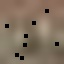

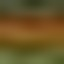

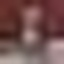

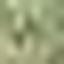

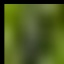

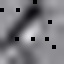

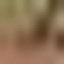

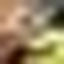

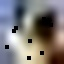

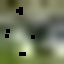

In [12]:
import cv2
from google.colab.patches import cv2_imshow

for i in range(10):
    img = cv2.imread(f"aug_train_shuffle_64/{train_data[i][0]}", cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)

##### Kaggle Augmented Dataset

In [13]:
import os
import sys
import pandas as pd
import cv2
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KaggleDataset(nn.Module):
    def __init__(self, mode = 'train'):
        super(KaggleDataset, self).__init__()
        self.mode = mode

        if mode == 'train':
            self.dataset = train_data
        else:
            self.dataset = val_data
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx][0]

        if self.mode == 'train':
            img = cv2.imread(os.path.join('aug_train_shuffle_64', img_name))   
        else:
            img = cv2.imread(os.path.join('train_shuffle_64', img_name))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #convert image from BGR to RGB format

        super_class = torch.tensor(self.dataset[idx][1], dtype = torch.float32)
        sub_class = torch.tensor(self.dataset[idx][2], dtype = torch.float32)

        apply_transform = self.transform_data()
        image = apply_transform(image = img)['image']

        return image, super_class, sub_class

    def transform_data(self):

        if self.mode == 'train':
            transform_func = A.Compose(
              [
                  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1), 
                  ToTensorV2(p=1),
              ])
        else:     #augmentations during validation and testing
            transform_func = A.Compose(
            [   
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),
                ToTensorV2(p=1),
            ])
    
        return transform_func

##### Kaggle Augmented Dataloader

In [14]:
from torch.utils.data import DataLoader

train_dataset = KaggleDataset(mode='train')
val_dataset = KaggleDataset(mode='val')
    
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle = False)

print(len(train_loader))
print(len(val_loader))

495
23


### Created Augmented Data Joint Super Sub Class Model

##### Joint training utility function

In [ ]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs, sub_outputs = model(images)

                        super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 5 * super_loss + 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                print(f"Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")

                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the Joint model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the Swin Transformer model trained on ImageNet
backbone_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
backbone_model.head = nn.Identity()

# Set the DropOut value in the backbone model
def set_dropout_p(m, p):
    if isinstance(m, nn.Dropout):
        m.p = p

backbone_model.apply(lambda m: set_dropout_p(m, p = 0.25))

class AugmentedModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes and 89 sub classes
        self.superclass = nn.Linear(in_features = 768, out_features = 3)
        self.subclass = nn.Linear(in_features = 768, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
augmented_joint_model = AugmentedModel(backbone_model)
augmented_joint_model = augmented_joint_model.to(device, non_blocking = True)

##### Train the Joint model

###### Freeze all the layers except Classifier layers (phase 1)

In [ ]:
# Training the model (with all backbone frozen)
for param in augmented_joint_model.parameters():
    param.requires_grad = True

for param in augmented_joint_model.backbone.parameters():
    param.requires_grad = False

summary(augmented_joint_model, (3, 64, 64))

# Check number of parameters
pytorch_total_params = sum(p.numel() for p in augmented_joint_model.parameters())
print(pytorch_total_params)

trainable_params = []

for name, param in augmented_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    augmented_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_SwinT_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:20<00:00, 23.94batch/s, loss=13.6, sub_class_accuracy=0, super_class_accuracy=0.583]


Epoch 0 train Super Class loss: 4.983701880770901 Super Class acc: 0.5053057074546814
Sub Class loss: 8.876493526745952 Sub Class acc: 0.024949468672275543


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 24.48batch/s, loss=13.4, sub_class_accuracy=0.0333, super_class_accuracy=0.533]


Epoch 0 val Super Class loss: 4.379552537803754 Super Class acc: 0.5967302322387695
Sub Class loss: 8.46478257192253 Sub Class acc: 0.058583106845617294
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:21<00:00, 23.48batch/s, loss=12.3, sub_class_accuracy=0.125, super_class_accuracy=0.667]


Epoch 1 train Super Class loss: 4.447518702918318 Super Class acc: 0.605419397354126
Sub Class loss: 8.478429579867324 Sub Class acc: 0.05482567101716995


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 25.87batch/s, loss=12.9, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 1 val Super Class loss: 4.227945938584591 Super Class acc: 0.611716628074646
Sub Class loss: 8.027168364875648 Sub Class acc: 0.09945503622293472
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:28<00:00, 17.26batch/s, loss=12.2, sub_class_accuracy=0.167, super_class_accuracy=0.708]


Epoch 2 train Super Class loss: 4.201622383199357 Super Class acc: 0.6344744563102722
Sub Class loss: 8.188273412281362 Sub Class acc: 0.0792066678404808


Epoch 2 val: 100%|██████████| 23/23 [00:01<00:00, 14.40batch/s, loss=12.8, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 2 val Super Class loss: 4.033261034079404 Super Class acc: 0.6457765698432922
Sub Class loss: 7.763533111489111 Sub Class acc: 0.1130790188908577
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:25<00:00, 19.76batch/s, loss=12.6, sub_class_accuracy=0.0417, super_class_accuracy=0.625]


Epoch 3 train Super Class loss: 4.1565402346828355 Super Class acc: 0.6374431252479553
Sub Class loss: 8.004291351784836 Sub Class acc: 0.09405002743005753


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 25.17batch/s, loss=12.7, sub_class_accuracy=0.0333, super_class_accuracy=0.567]


Epoch 3 val Super Class loss: 4.079655071857514 Super Class acc: 0.6348773837089539
Sub Class loss: 7.606210919102141 Sub Class acc: 0.12942779064178467
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:22<00:00, 22.47batch/s, loss=10.5, sub_class_accuracy=0.167, super_class_accuracy=0.708]


Epoch 4 train Super Class loss: 4.089567330734123 Super Class acc: 0.6431909799575806
Sub Class loss: 7.863306313467001 Sub Class acc: 0.10087165236473083


Epoch 4 val: 100%|██████████| 23/23 [00:01<00:00, 19.45batch/s, loss=12.5, sub_class_accuracy=0.0333, super_class_accuracy=0.6]


Epoch 4 val Super Class loss: 3.926862854236478 Super Class acc: 0.6525885462760925
Sub Class loss: 7.496757348811594 Sub Class acc: 0.12534059584140778
--------------------
Best Super Class val acc: 0.6525885462760925
Best Sub Class val acc: 0.12942779064178467
Average Time taken for an epoch: 25.090459203720094 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [ ]:
# Training the model (with some backbone frozen)
for param in augmented_joint_model.parameters():
    param.requires_grad = True

for param in augmented_joint_model.backbone.features[:7].parameters():
    param.requires_grad = False

for idx, (name, param) in enumerate(augmented_joint_model.backbone.features[7].named_parameters()):
    #print(name, idx)
    if idx > 15:
        param.requires_grad = True

summary(augmented_joint_model, (3, 64, 64))

trainable_params = []

for name, param in augmented_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 6
initial_epoch = 5
learning_rate = 2e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    augmented_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_SwinT_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:29<00:00, 16.75batch/s, loss=10.1, sub_class_accuracy=0.167, super_class_accuracy=0.792]


Epoch 5 train Super Class loss: 3.9202724141927607 Super Class acc: 0.6598660945892334
Sub Class loss: 7.407000721434621 Sub Class acc: 0.12158918380737305


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 25.25batch/s, loss=11.7, sub_class_accuracy=0, super_class_accuracy=0.667]


Epoch 5 val Super Class loss: 3.3051128153580085 Super Class acc: 0.7125340700149536
Sub Class loss: 7.068792158641347 Sub Class acc: 0.1607629358768463
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:29<00:00, 16.93batch/s, loss=10.4, sub_class_accuracy=0.208, super_class_accuracy=0.667]


Epoch 6 train Super Class loss: 3.6338819952671306 Super Class acc: 0.6848787069320679
Sub Class loss: 6.9557834789571045 Sub Class acc: 0.15045477449893951


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 25.63batch/s, loss=10.7, sub_class_accuracy=0.0333, super_class_accuracy=0.767]


Epoch 6 val Super Class loss: 3.3248427055512204 Super Class acc: 0.7384195923805237
Sub Class loss: 6.853907699481018 Sub Class acc: 0.18119890987873077
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:28<00:00, 17.08batch/s, loss=10.2, sub_class_accuracy=0.208, super_class_accuracy=0.708]


Epoch 7 train Super Class loss: 3.4320608419923846 Super Class acc: 0.7083754539489746
Sub Class loss: 6.647474350623256 Sub Class acc: 0.17477260529994965


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 25.93batch/s, loss=12, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 7 val Super Class loss: 3.200872546970357 Super Class acc: 0.7370572090148926
Sub Class loss: 6.745702221218182 Sub Class acc: 0.19891007244586945
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:29<00:00, 16.90batch/s, loss=8.36, sub_class_accuracy=0.292, super_class_accuracy=0.875]


Epoch 8 train Super Class loss: 3.3611003398714554 Super Class acc: 0.716713011264801
Sub Class loss: 6.490049989612612 Sub Class acc: 0.1843734234571457


Epoch 8 val: 100%|██████████| 23/23 [00:01<00:00, 19.62batch/s, loss=10.6, sub_class_accuracy=0.0667, super_class_accuracy=0.867]


Epoch 8 val Super Class loss: 2.8514592572843673 Super Class acc: 0.7724795341491699
Sub Class loss: 6.589387319393314 Sub Class acc: 0.18256130814552307
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:29<00:00, 16.85batch/s, loss=8.59, sub_class_accuracy=0.208, super_class_accuracy=0.792]


Epoch 9 train Super Class loss: 3.267097496335828 Super Class acc: 0.7259979844093323
Sub Class loss: 6.343342673844795 Sub Class acc: 0.193279430270195


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 25.22batch/s, loss=10.3, sub_class_accuracy=0.1, super_class_accuracy=0.867]


Epoch 9 val Super Class loss: 3.062692168460555 Super Class acc: 0.7506811618804932
Sub Class loss: 6.758338207120142 Sub Class acc: 0.19891007244586945
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:28<00:00, 17.17batch/s, loss=9.71, sub_class_accuracy=0.125, super_class_accuracy=0.708]


Epoch 10 train Super Class loss: 3.159582997103301 Super Class acc: 0.7374936938285828
Sub Class loss: 6.211187295446256 Sub Class acc: 0.20837543904781342


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 26.83batch/s, loss=10.9, sub_class_accuracy=0.0333, super_class_accuracy=0.8]


Epoch 10 val Super Class loss: 3.026217949000626 Super Class acc: 0.7561307549476624
Sub Class loss: 6.579327609298664 Sub Class acc: 0.20299726724624634
--------------------
Best Super Class val acc: 0.7724795341491699
Best Sub Class val acc: 0.20299726724624634
Average Time taken for an epoch: 30.490694999694824 sec


###### Unfreeze all the layers in the network (phase 3)

In [ ]:
# Training the model (with everything unfrozen)
for param in augmented_joint_model.parameters():
    param.requires_grad = True

summary(augmented_joint_model, (3, 64, 64))

trainable_params = []

for name, param in augmented_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [ ]:
epochs = 10
initial_epoch = 11
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    augmented_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_SwinT_unfrozen'
)

Epoch 11 train: 100%|██████████| 495/495 [00:50<00:00,  9.88batch/s, loss=6.34, sub_class_accuracy=0.208, super_class_accuracy=0.917]


Epoch 11 train Super Class loss: 2.90409160298853 Super Class acc: 0.763327419757843
Sub Class loss: 6.010507477359859 Sub Class acc: 0.2151339054107666


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 24.40batch/s, loss=9.34, sub_class_accuracy=0.2, super_class_accuracy=0.8]


Epoch 11 val Super Class loss: 2.5961006995117955 Super Class acc: 0.7806539535522461
Sub Class loss: 6.081120549495603 Sub Class acc: 0.2193460464477539
--------------------


Epoch 12 train: 100%|██████████| 495/495 [00:50<00:00,  9.75batch/s, loss=6.74, sub_class_accuracy=0.25, super_class_accuracy=0.917]


Epoch 12 train Super Class loss: 2.1779163803730186 Super Class acc: 0.8294593095779419
Sub Class loss: 5.0498851688899675 Sub Class acc: 0.30185699462890625


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 25.43batch/s, loss=8.85, sub_class_accuracy=0.1, super_class_accuracy=0.9]


Epoch 12 val Super Class loss: 2.008878727943436 Super Class acc: 0.8542234301567078
Sub Class loss: 5.704824654217962 Sub Class acc: 0.24523159861564636
--------------------


Epoch 13 train: 100%|██████████| 495/495 [00:50<00:00,  9.71batch/s, loss=6.25, sub_class_accuracy=0.417, super_class_accuracy=0.75]


Epoch 13 train Super Class loss: 1.769314571695535 Super Class acc: 0.8657150268554688
Sub Class loss: 4.38700241220907 Sub Class acc: 0.3740525543689728


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 25.60batch/s, loss=9.15, sub_class_accuracy=0.133, super_class_accuracy=0.867]


Epoch 13 val Super Class loss: 2.0964675938725796 Super Class acc: 0.8405994176864624
Sub Class loss: 5.832951414487667 Sub Class acc: 0.26294276118278503
--------------------


Epoch 14 train: 100%|██████████| 495/495 [00:50<00:00,  9.76batch/s, loss=5.26, sub_class_accuracy=0.583, super_class_accuracy=0.833]


Epoch 14 train Super Class loss: 1.4283555354913597 Super Class acc: 0.8899065256118774
Sub Class loss: 3.8273927357053443 Sub Class acc: 0.43923699855804443


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 24.75batch/s, loss=8.87, sub_class_accuracy=0.167, super_class_accuracy=0.867]


Epoch 14 val Super Class loss: 2.2238092156944225 Super Class acc: 0.8501362204551697
Sub Class loss: 5.9135843817479605 Sub Class acc: 0.23841962218284607
--------------------


Epoch 15 train: 100%|██████████| 495/495 [00:49<00:00,  9.95batch/s, loss=4.97, sub_class_accuracy=0.625, super_class_accuracy=0.833]


Epoch 15 train Super Class loss: 1.1798915530151644 Super Class acc: 0.9120768308639526
Sub Class loss: 3.283147601902997 Sub Class acc: 0.5072005987167358


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 24.78batch/s, loss=10.5, sub_class_accuracy=0.1, super_class_accuracy=0.867]


Epoch 15 val Super Class loss: 2.041301733791341 Super Class acc: 0.8678473830223083
Sub Class loss: 6.338790350454055 Sub Class acc: 0.25476840138435364
--------------------


Epoch 16 train: 100%|██████████| 495/495 [00:49<00:00,  9.92batch/s, loss=4.56, sub_class_accuracy=0.667, super_class_accuracy=0.833]


Epoch 16 train Super Class loss: 0.9046003106132549 Super Class acc: 0.9309626221656799
Sub Class loss: 2.7710710521175623 Sub Class acc: 0.5711849331855774


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 25.34batch/s, loss=13, sub_class_accuracy=0.267, super_class_accuracy=0.767]


Epoch 16 val Super Class loss: 2.470603538144187 Super Class acc: 0.85694819688797
Sub Class loss: 6.699765192390463 Sub Class acc: 0.2711171507835388
--------------------


Epoch 17 train: 100%|██████████| 495/495 [00:51<00:00,  9.69batch/s, loss=3.04, sub_class_accuracy=0.625, super_class_accuracy=0.958]


Epoch 17 train Super Class loss: 0.7698123219991013 Super Class acc: 0.9424583315849304
Sub Class loss: 2.338210242634292 Sub Class acc: 0.6321374177932739


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 24.96batch/s, loss=11, sub_class_accuracy=0.233, super_class_accuracy=0.767]


Epoch 17 val Super Class loss: 2.391195175433354 Super Class acc: 0.8610354065895081
Sub Class loss: 6.498975449751768 Sub Class acc: 0.29836511611938477
--------------------


Epoch 18 train: 100%|██████████| 495/495 [00:49<00:00,  9.91batch/s, loss=2.29, sub_class_accuracy=0.667, super_class_accuracy=1]


Epoch 18 train Super Class loss: 0.595147209183161 Super Class acc: 0.9578701257705688
Sub Class loss: 1.9522463711540528 Sub Class acc: 0.6884790062904358


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 24.70batch/s, loss=10.4, sub_class_accuracy=0.3, super_class_accuracy=0.867]


Epoch 18 val Super Class loss: 2.8064099680987624 Super Class acc: 0.8555858135223389
Sub Class loss: 7.3316411504303725 Sub Class acc: 0.2643051743507385
--------------------


Epoch 19 train: 100%|██████████| 495/495 [00:50<00:00,  9.76batch/s, loss=1.87, sub_class_accuracy=0.75, super_class_accuracy=0.958]


Epoch 19 train Super Class loss: 0.5399684086225517 Super Class acc: 0.9596387147903442
Sub Class loss: 1.662152551472217 Sub Class acc: 0.7351566553115845


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 25.19batch/s, loss=15.3, sub_class_accuracy=0.2, super_class_accuracy=0.8]


Epoch 19 val Super Class loss: 3.2287623170935817 Super Class acc: 0.829700231552124
Sub Class loss: 7.812186436042474 Sub Class acc: 0.2738419473171234
--------------------


Epoch 20 train: 100%|██████████| 495/495 [00:49<00:00,  9.94batch/s, loss=2.43, sub_class_accuracy=0.625, super_class_accuracy=0.958]


Epoch 20 train Super Class loss: 0.4583072795910538 Super Class acc: 0.9677867889404297
Sub Class loss: 1.3806180893139985 Sub Class acc: 0.77311772108078


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 25.54batch/s, loss=12, sub_class_accuracy=0.367, super_class_accuracy=0.833]

Epoch 20 val Super Class loss: 2.557687013935328 Super Class acc: 0.8623977899551392
Sub Class loss: 7.668273746480084 Sub Class acc: 0.290190726518631
--------------------
Best Super Class val acc: 0.8678473830223083
Best Sub Class val acc: 0.29836511611938477
Average Time taken for an epoch: 51.51663687229156 sec


### Augmented EfficientNetB3 Joint Super Sub Class model

##### Joint training utility function

In [ ]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs, sub_outputs = model(images)

                        super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 5 * super_loss + 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                print(f"Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")

                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the EfficientNetB3 model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the EfficientNetB3 model trained on ImageNet
backbone_model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
backbone_model.classifier = nn.Identity()


class EffnetB3JointModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 1536, out_features = 3)
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 1536, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
effnetb3_joint_model = EffnetB3JointModel(backbone_model)
effnetb3_joint_model = effnetb3_joint_model.to(device, non_blocking = True)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

##### Train the EfficientNetB3 model

###### Freeze all the layers except Classifier layers (phase 1)

In [ ]:
# Training the model (with all backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_EffnetB3_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:22<00:00, 21.68batch/s, loss=13.6, sub_class_accuracy=0, super_class_accuracy=0.583]


Epoch 0 train Super Class loss: 5.154709285892219 Super Class acc: 0.46551287174224854
Sub Class loss: 8.907699087161257 Sub Class acc: 0.020780697464942932


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 27.01batch/s, loss=13.6, sub_class_accuracy=0, super_class_accuracy=0.533]


Epoch 0 val Super Class loss: 4.9173444460783085 Super Class acc: 0.5299727320671082
Sub Class loss: 8.821673120399911 Sub Class acc: 0.029972750693559647
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:23<00:00, 20.70batch/s, loss=13.1, sub_class_accuracy=0, super_class_accuracy=0.583]


Epoch 1 train Super Class loss: 4.797294731240131 Super Class acc: 0.5414982438087463
Sub Class loss: 8.618030500387892 Sub Class acc: 0.04194037243723869


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 25.76batch/s, loss=13.3, sub_class_accuracy=0, super_class_accuracy=0.6]


Epoch 1 val Super Class loss: 4.821040640897257 Super Class acc: 0.5749318599700928
Sub Class loss: 8.693347457968896 Sub Class acc: 0.04359672963619232
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:23<00:00, 21.34batch/s, loss=13.6, sub_class_accuracy=0.0417, super_class_accuracy=0.583]


Epoch 2 train Super Class loss: 4.688876484186135 Super Class acc: 0.5567205548286438
Sub Class loss: 8.419576119629646 Sub Class acc: 0.06284739822149277


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 25.99batch/s, loss=13.7, sub_class_accuracy=0.0333, super_class_accuracy=0.467]


Epoch 2 val Super Class loss: 4.671958075881979 Super Class acc: 0.5885558724403381
Sub Class loss: 8.570282187708717 Sub Class acc: 0.047683924436569214
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:22<00:00, 21.68batch/s, loss=13.3, sub_class_accuracy=0.0833, super_class_accuracy=0.5]


Epoch 3 train Super Class loss: 4.634066871346218 Super Class acc: 0.5668267011642456
Sub Class loss: 8.27061823487824 Sub Class acc: 0.0741536095738411


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 24.83batch/s, loss=12.9, sub_class_accuracy=0.0333, super_class_accuracy=0.667]


Epoch 3 val Super Class loss: 4.67648205786375 Super Class acc: 0.5653951168060303
Sub Class loss: 8.550964794626678 Sub Class acc: 0.058583106845617294
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:22<00:00, 21.55batch/s, loss=11.9, sub_class_accuracy=0.0833, super_class_accuracy=0.667]


Epoch 4 train Super Class loss: 4.598122831695666 Super Class acc: 0.5768696069717407
Sub Class loss: 8.15479433253415 Sub Class acc: 0.08084891736507416


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 26.86batch/s, loss=13.1, sub_class_accuracy=0.0333, super_class_accuracy=0.667]

Epoch 4 val Super Class loss: 4.62255221621542 Super Class acc: 0.580381453037262
Sub Class loss: 8.541774128698199 Sub Class acc: 0.05040871724486351
--------------------
Best Super Class val acc: 0.5885558724403381
Best Sub Class val acc: 0.058583106845617294
Average Time taken for an epoch: 24.235797739028932 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [ ]:
# Training the model (with some backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.features[:7].parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 7
initial_epoch = 5
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_EffnetB3_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:25<00:00, 19.24batch/s, loss=10.1, sub_class_accuracy=0.292, super_class_accuracy=0.875]


Epoch 5 train Super Class loss: 4.209537612271466 Super Class acc: 0.6260105967521667
Sub Class loss: 7.664932960570009 Sub Class acc: 0.10680899769067764


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 26.60batch/s, loss=12.1, sub_class_accuracy=0.0333, super_class_accuracy=0.667]


Epoch 5 val Super Class loss: 3.8054716846923413 Super Class acc: 0.6743869185447693
Sub Class loss: 7.769146157870176 Sub Class acc: 0.09945503622293472
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:27<00:00, 18.31batch/s, loss=10.4, sub_class_accuracy=0.25, super_class_accuracy=0.625]


Epoch 6 train Super Class loss: 3.7797248012613562 Super Class acc: 0.671298623085022
Sub Class loss: 7.039763798070352 Sub Class acc: 0.14818090200424194


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 26.34batch/s, loss=11.6, sub_class_accuracy=0.1, super_class_accuracy=0.633]


Epoch 6 val Super Class loss: 3.830016174173485 Super Class acc: 0.6798365116119385
Sub Class loss: 7.554420721953181 Sub Class acc: 0.11580381542444229
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:25<00:00, 19.34batch/s, loss=8.86, sub_class_accuracy=0.125, super_class_accuracy=0.792]


Epoch 7 train Super Class loss: 3.5806321063205533 Super Class acc: 0.6884158849716187
Sub Class loss: 6.66895954773967 Sub Class acc: 0.17445679008960724


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 27.26batch/s, loss=12, sub_class_accuracy=0.0667, super_class_accuracy=0.7]


Epoch 7 val Super Class loss: 3.7332749374880776 Super Class acc: 0.6607629060745239
Sub Class loss: 7.52568271179615 Sub Class acc: 0.10762942582368851
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:25<00:00, 19.20batch/s, loss=10.5, sub_class_accuracy=0.167, super_class_accuracy=0.625]


Epoch 8 train Super Class loss: 3.357493525927208 Super Class acc: 0.7140601277351379
Sub Class loss: 6.375044985333135 Sub Class acc: 0.20149065554141998


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 26.09batch/s, loss=12.2, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 8 val Super Class loss: 3.6458208052598815 Super Class acc: 0.6798365116119385
Sub Class loss: 7.480375128805799 Sub Class acc: 0.09809264540672302
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:26<00:00, 19.03batch/s, loss=8.67, sub_class_accuracy=0.208, super_class_accuracy=0.708]


Epoch 9 train Super Class loss: 3.239613444652143 Super Class acc: 0.7285245060920715
Sub Class loss: 6.086754673836869 Sub Class acc: 0.22909297049045563


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 26.43batch/s, loss=11.8, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 9 val Super Class loss: 3.508326636185763 Super Class acc: 0.6934604644775391
Sub Class loss: 7.519376099921702 Sub Class acc: 0.1089918240904808
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:26<00:00, 18.47batch/s, loss=9.05, sub_class_accuracy=0.333, super_class_accuracy=0.792]


Epoch 10 train Super Class loss: 3.100412232277067 Super Class acc: 0.7350934743881226
Sub Class loss: 5.826086495367188 Sub Class acc: 0.24955785274505615


Epoch 10 val: 100%|██████████| 23/23 [00:01<00:00, 18.84batch/s, loss=12.4, sub_class_accuracy=0.167, super_class_accuracy=0.567]


Epoch 10 val Super Class loss: 3.706071711366118 Super Class acc: 0.6594005227088928
Sub Class loss: 7.559822264419265 Sub Class acc: 0.13079018890857697
--------------------


Epoch 11 train: 100%|██████████| 495/495 [00:26<00:00, 19.00batch/s, loss=7.04, sub_class_accuracy=0.375, super_class_accuracy=0.875]


Epoch 11 train Super Class loss: 2.9917170105858726 Super Class acc: 0.7468418478965759
Sub Class loss: 5.591209875928928 Sub Class acc: 0.279560387134552


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 25.92batch/s, loss=12.1, sub_class_accuracy=0.133, super_class_accuracy=0.667]

Epoch 11 val Super Class loss: 3.7814724071798924 Super Class acc: 0.6893733143806458
Sub Class loss: 7.7429101629543045 Sub Class acc: 0.10762942582368851
--------------------
Best Super Class val acc: 0.6934604644775391
Best Sub Class val acc: 0.13079018890857697
Average Time taken for an epoch: 27.20611776624407 sec


###### Unfreeze all the layers in the network (phase 3)

In [ ]:
# Training the model (with everything unfrozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 10
initial_epoch = 12
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='Augment_Joint_EffnetB3_unfrozen'
)

Epoch 12 train: 100%|██████████| 495/495 [00:55<00:00,  9.00batch/s, loss=8, sub_class_accuracy=0.292, super_class_accuracy=0.667]


Epoch 12 train Super Class loss: 2.6805449351329522 Super Class acc: 0.7785497903823853
Sub Class loss: 5.245873436053152 Sub Class acc: 0.30097270011901855


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 23.62batch/s, loss=8.62, sub_class_accuracy=0.2, super_class_accuracy=0.867]


Epoch 12 val Super Class loss: 2.537018246238173 Super Class acc: 0.7942779064178467
Sub Class loss: 6.547255312064688 Sub Class acc: 0.18528610467910767
--------------------


Epoch 13 train: 100%|██████████| 495/495 [00:55<00:00,  8.91batch/s, loss=5.68, sub_class_accuracy=0.417, super_class_accuracy=0.875]


Epoch 13 train Super Class loss: 1.8020821010723085 Super Class acc: 0.8578196167945862
Sub Class loss: 4.058249134436709 Sub Class acc: 0.43273118138313293


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 26.06batch/s, loss=9.85, sub_class_accuracy=0.233, super_class_accuracy=0.8]


Epoch 13 val Super Class loss: 2.585096673517201 Super Class acc: 0.8051770925521851
Sub Class loss: 6.62879465971071 Sub Class acc: 0.20572206377983093
--------------------


Epoch 14 train: 100%|██████████| 495/495 [00:54<00:00,  9.11batch/s, loss=3.43, sub_class_accuracy=0.667, super_class_accuracy=0.875]


Epoch 14 train Super Class loss: 1.1656529360750578 Super Class acc: 0.9125189781188965
Sub Class loss: 2.9954167668900147 Sub Class acc: 0.565563440322876


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 25.31batch/s, loss=9.17, sub_class_accuracy=0.2, super_class_accuracy=0.7]


Epoch 14 val Super Class loss: 2.523644311145476 Super Class acc: 0.8269754648208618
Sub Class loss: 6.816163102027831 Sub Class acc: 0.2193460464477539
--------------------


Epoch 15 train: 100%|██████████| 495/495 [00:54<00:00,  9.04batch/s, loss=2.53, sub_class_accuracy=0.625, super_class_accuracy=1]


Epoch 15 train Super Class loss: 0.7457028958662223 Super Class acc: 0.9436584115028381
Sub Class loss: 2.1002498919943355 Sub Class acc: 0.6931530833244324


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 25.58batch/s, loss=9.36, sub_class_accuracy=0.233, super_class_accuracy=0.767]


Epoch 15 val Super Class loss: 2.877853246816822 Super Class acc: 0.8188011050224304
Sub Class loss: 7.144142145681771 Sub Class acc: 0.23024523258209229
--------------------


Epoch 16 train: 100%|██████████| 495/495 [00:54<00:00,  9.13batch/s, loss=2.32, sub_class_accuracy=0.75, super_class_accuracy=0.917]


Epoch 16 train Super Class loss: 0.6332701836449591 Super Class acc: 0.9525012373924255
Sub Class loss: 1.5787762387826505 Sub Class acc: 0.7744441628456116


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 26.12batch/s, loss=10.2, sub_class_accuracy=0.167, super_class_accuracy=0.8]


Epoch 16 val Super Class loss: 2.8862348755146567 Super Class acc: 0.8283378481864929
Sub Class loss: 7.481370593286665 Sub Class acc: 0.2261580377817154
--------------------


Epoch 17 train: 100%|██████████| 495/495 [00:53<00:00,  9.25batch/s, loss=2.16, sub_class_accuracy=0.792, super_class_accuracy=0.958]


Epoch 17 train Super Class loss: 0.5192794179813979 Super Class acc: 0.9619125723838806
Sub Class loss: 1.179212431705257 Sub Class acc: 0.829206645488739


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 24.77batch/s, loss=8.8, sub_class_accuracy=0.233, super_class_accuracy=0.867]


Epoch 17 val Super Class loss: 2.9944177804266077 Super Class acc: 0.8365122675895691
Sub Class loss: 8.034971420381634 Sub Class acc: 0.2166212499141693
--------------------


Epoch 18 train: 100%|██████████| 495/495 [00:55<00:00,  8.97batch/s, loss=3.12, sub_class_accuracy=0.75, super_class_accuracy=0.833]


Epoch 18 train Super Class loss: 0.43006872330491536 Super Class acc: 0.9701869487762451
Sub Class loss: 0.853621964234183 Sub Class acc: 0.8802425265312195


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 24.81batch/s, loss=9.82, sub_class_accuracy=0.267, super_class_accuracy=0.9]


Epoch 18 val Super Class loss: 3.122325611455564 Super Class acc: 0.8392370343208313
Sub Class loss: 8.219114776528174 Sub Class acc: 0.2288828343153
--------------------


Epoch 19 train: 100%|██████████| 495/495 [00:53<00:00,  9.17batch/s, loss=1.4, sub_class_accuracy=0.792, super_class_accuracy=1]


Epoch 19 train Super Class loss: 0.3807624521525977 Super Class acc: 0.9735977649688721
Sub Class loss: 0.7358348239184992 Sub Class acc: 0.8955280184745789


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 26.77batch/s, loss=11.4, sub_class_accuracy=0.333, super_class_accuracy=0.833]


Epoch 19 val Super Class loss: 3.315200755316815 Super Class acc: 0.8283378481864929
Sub Class loss: 8.42726004545955 Sub Class acc: 0.20708446204662323
--------------------


Epoch 20 train: 100%|██████████| 495/495 [00:54<00:00,  9.15batch/s, loss=0.986, sub_class_accuracy=0.875, super_class_accuracy=0.958]


Epoch 20 train Super Class loss: 0.3499263991141045 Super Class acc: 0.9760611653327942
Sub Class loss: 0.6134947946783628 Sub Class acc: 0.9123294353485107


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 25.72batch/s, loss=14, sub_class_accuracy=0.267, super_class_accuracy=0.8]


Epoch 20 val Super Class loss: 3.7286427267890536 Super Class acc: 0.8188011050224304
Sub Class loss: 8.757420955626776 Sub Class acc: 0.2288828343153
--------------------


Epoch 21 train: 100%|██████████| 495/495 [00:53<00:00,  9.30batch/s, loss=1.2, sub_class_accuracy=0.833, super_class_accuracy=1]


Epoch 21 train Super Class loss: 0.3177391367052889 Super Class acc: 0.9780823588371277
Sub Class loss: 0.5284634585510667 Sub Class acc: 0.924330472946167


Epoch 21 val: 100%|██████████| 23/23 [00:00<00:00, 25.96batch/s, loss=13.5, sub_class_accuracy=0.2, super_class_accuracy=0.833]

Epoch 21 val Super Class loss: 3.418962889698611 Super Class acc: 0.8337874412536621
Sub Class loss: 9.241045377559818 Sub Class acc: 0.21253405511379242
--------------------
Best Super Class val acc: 0.8392370343208313
Best Sub Class val acc: 0.23024523258209229
Average Time taken for an epoch: 55.44719407558441 sec


### Dropout + Augmented EfficientNetB3 Joint Super Sub Class

##### Joint training utility function

In [ ]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs, sub_outputs = model(images)

                        super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 5 * super_loss + 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                print(f"Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")

                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the EfficientNetB3 model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the EfficientNetB3 model trained on ImageNet
backbone_model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
backbone_model.classifier = nn.Identity()


# Add Dropout layers after the activation function as per this paper http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
#backbone_model.features[0].add_module('3', nn.Dropout(p = 0.2))

#backbone_model.features[1][0].block[0].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[1][1].block[0].add_module('3', nn.Dropout(p = 0.1))

#backbone_model.features[2][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][2].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[3][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][2].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[4][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][3].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[5][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][3].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[6][0].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][1].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][2].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][3].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][4].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][5].block[1].add_module('3', nn.Dropout(p = 0.2))

backbone_model.features[7][0].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[7][1].block[1].add_module('3', nn.Dropout(p = 0.2))

# print(backbone_model)

class EffnetB3JointModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 1536, out_features = 3)
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 1536, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
effnetb3_joint_model = EffnetB3JointModel(backbone_model)
effnetb3_joint_model = effnetb3_joint_model.to(device, non_blocking = True)

##### Train the EfficientNetB3 model

###### Freeze all the layers except Classifier layers (phase 1)

In [ ]:
# Training the model (with all backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='DropOut_Augment_Joint_EffnetB3_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:22<00:00, 21.69batch/s, loss=14.3, sub_class_accuracy=0, super_class_accuracy=0.417]


Epoch 0 train Super Class loss: 5.302411928931049 Super Class acc: 0.4340575933456421
Sub Class loss: 8.969053840926346 Sub Class acc: 0.0156644769012928


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 26.75batch/s, loss=14, sub_class_accuracy=0, super_class_accuracy=0.5]


Epoch 0 val Super Class loss: 4.9219664492789015 Super Class acc: 0.5040872097015381
Sub Class loss: 8.86778015531701 Sub Class acc: 0.025885557755827904
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:23<00:00, 20.93batch/s, loss=13.6, sub_class_accuracy=0, super_class_accuracy=0.542]


Epoch 1 train Super Class loss: 5.120258005566522 Super Class acc: 0.48010358214378357
Sub Class loss: 8.859968029772048 Sub Class acc: 0.02387569472193718


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 27.00batch/s, loss=13.4, sub_class_accuracy=0, super_class_accuracy=0.667]


Epoch 1 val Super Class loss: 4.817773829688818 Super Class acc: 0.5381471514701843
Sub Class loss: 8.767902532780203 Sub Class acc: 0.024523161351680756
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:22<00:00, 22.21batch/s, loss=13.8, sub_class_accuracy=0.0417, super_class_accuracy=0.417]


Epoch 2 train Super Class loss: 5.046160516562999 Super Class acc: 0.4938731789588928
Sub Class loss: 8.768305982827778 Sub Class acc: 0.030634159222245216


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 27.42batch/s, loss=13.2, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 2 val Super Class loss: 4.692465422588733 Super Class acc: 0.5667575001716614
Sub Class loss: 8.666921748127535 Sub Class acc: 0.05040871724486351
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:22<00:00, 22.01batch/s, loss=13.7, sub_class_accuracy=0.0833, super_class_accuracy=0.417]


Epoch 3 train Super Class loss: 5.008617619813965 Super Class acc: 0.5045477747917175
Sub Class loss: 8.70051661641264 Sub Class acc: 0.033287014812231064


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 26.68batch/s, loss=13.1, sub_class_accuracy=0.0333, super_class_accuracy=0.6]


Epoch 3 val Super Class loss: 4.647954790078977 Super Class acc: 0.5790190696716309
Sub Class loss: 8.596884504001212 Sub Class acc: 0.04904632270336151
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:22<00:00, 21.72batch/s, loss=13.3, sub_class_accuracy=0.0417, super_class_accuracy=0.583]


Epoch 4 train Super Class loss: 4.979723752930407 Super Class acc: 0.5077690482139587
Sub Class loss: 8.656200317375102 Sub Class acc: 0.03625568374991417


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 27.08batch/s, loss=12.9, sub_class_accuracy=0.0333, super_class_accuracy=0.567]


Epoch 4 val Super Class loss: 4.60327772174934 Super Class acc: 0.5735694766044617
Sub Class loss: 8.532769216178874 Sub Class acc: 0.05994550138711929
--------------------
Best Super Class val acc: 0.5790190696716309
Best Sub Class val acc: 0.05994550138711929
Average Time taken for an epoch: 23.87728409767151 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [ ]:
# Training the model (with some backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.features[:7].parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 7
initial_epoch = 5
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='DropOut_Augment_Joint_EffnetB3_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:25<00:00, 19.50batch/s, loss=12.8, sub_class_accuracy=0.0833, super_class_accuracy=0.542]


Epoch 5 train Super Class loss: 4.7864117769655286 Super Class acc: 0.5370136499404907
Sub Class loss: 8.393641234287534 Sub Class acc: 0.047498736530542374


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 27.09batch/s, loss=11.7, sub_class_accuracy=0, super_class_accuracy=0.667]


Epoch 5 val Super Class loss: 4.061679001237781 Super Class acc: 0.6267029643058777
Sub Class loss: 7.971830105586663 Sub Class acc: 0.07765667140483856
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:27<00:00, 18.05batch/s, loss=12.2, sub_class_accuracy=0.0417, super_class_accuracy=0.625]


Epoch 6 train Super Class loss: 4.538684173206177 Super Class acc: 0.5747852325439453
Sub Class loss: 8.099794087595503 Sub Class acc: 0.061394643038511276


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 26.53batch/s, loss=11.6, sub_class_accuracy=0, super_class_accuracy=0.733]


Epoch 6 val Super Class loss: 3.822490250544587 Super Class acc: 0.6634877324104309
Sub Class loss: 7.735055650612314 Sub Class acc: 0.10354223102331161
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:25<00:00, 19.33batch/s, loss=11.8, sub_class_accuracy=0.125, super_class_accuracy=0.542]


Epoch 7 train Super Class loss: 4.441033266390617 Super Class acc: 0.5865336060523987
Sub Class loss: 7.948602085344836 Sub Class acc: 0.0727008581161499


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 27.38batch/s, loss=11.2, sub_class_accuracy=0.0333, super_class_accuracy=0.767]


Epoch 7 val Super Class loss: 3.888058313232027 Super Class acc: 0.6416893601417542
Sub Class loss: 7.649046997933037 Sub Class acc: 0.10354223102331161
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:25<00:00, 19.56batch/s, loss=12.3, sub_class_accuracy=0.0833, super_class_accuracy=0.625]


Epoch 8 train Super Class loss: 4.374200604279997 Super Class acc: 0.5931025743484497
Sub Class loss: 7.872649340270565 Sub Class acc: 0.07585901767015457


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 27.57batch/s, loss=11.3, sub_class_accuracy=0.0333, super_class_accuracy=0.767]


Epoch 8 val Super Class loss: 3.6729775283901827 Super Class acc: 0.6852861046791077
Sub Class loss: 7.49209434265012 Sub Class acc: 0.09400545060634613
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:25<00:00, 19.35batch/s, loss=12.5, sub_class_accuracy=0.125, super_class_accuracy=0.458]


Epoch 9 train Super Class loss: 4.307176735348145 Super Class acc: 0.6040298342704773
Sub Class loss: 7.789302302828457 Sub Class acc: 0.08407023549079895


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 27.14batch/s, loss=11.4, sub_class_accuracy=0, super_class_accuracy=0.667]


Epoch 9 val Super Class loss: 3.5770697920134022 Super Class acc: 0.6825612783432007
Sub Class loss: 7.388827586368904 Sub Class acc: 0.1103542223572731
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:26<00:00, 18.74batch/s, loss=12.3, sub_class_accuracy=0, super_class_accuracy=0.542]


Epoch 10 train Super Class loss: 4.2896470508833255 Super Class acc: 0.6064299941062927
Sub Class loss: 7.760109419531145 Sub Class acc: 0.08337543904781342


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 26.57batch/s, loss=11.1, sub_class_accuracy=0.0333, super_class_accuracy=0.8]


Epoch 10 val Super Class loss: 3.522900265796308 Super Class acc: 0.7138964533805847
Sub Class loss: 7.4058525464840095 Sub Class acc: 0.1130790188908577
--------------------


Epoch 11 train: 100%|██████████| 495/495 [00:25<00:00, 19.46batch/s, loss=11.2, sub_class_accuracy=0.0417, super_class_accuracy=0.667]


Epoch 11 train Super Class loss: 4.264498742437532 Super Class acc: 0.6092091798782349
Sub Class loss: 7.684028193949448 Sub Class acc: 0.08855482935905457


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 27.37batch/s, loss=11, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 11 val Super Class loss: 3.609063479166265 Super Class acc: 0.6811988949775696
Sub Class loss: 7.36858236302472 Sub Class acc: 0.1103542223572731
--------------------
Best Super Class val acc: 0.7138964533805847
Best Sub Class val acc: 0.1130790188908577
Average Time taken for an epoch: 26.904880455562047 sec


###### Unfreeze all the layers in the network (phase 3)

In [ ]:
# Training the model (with everything unfrozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [ ]:
epochs = 10
initial_epoch = 12
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='DropOut_Augment_Joint_EffnetB3_unfrozen'
)

Epoch 12 train: 100%|██████████| 495/495 [00:53<00:00,  9.20batch/s, loss=10.4, sub_class_accuracy=0.0417, super_class_accuracy=0.667]


Epoch 12 train Super Class loss: 3.415805941853275 Super Class acc: 0.7097018957138062
Sub Class loss: 6.953833187030023 Sub Class acc: 0.1327059119939804


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 26.27batch/s, loss=9.5, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 12 val Super Class loss: 2.226374824544065 Super Class acc: 0.8310626745223999
Sub Class loss: 6.463599605196503 Sub Class acc: 0.1648501306772232
--------------------


Epoch 13 train: 100%|██████████| 495/495 [00:54<00:00,  9.07batch/s, loss=7.03, sub_class_accuracy=0.25, super_class_accuracy=0.833]


Epoch 13 train Super Class loss: 2.8014022297121888 Super Class acc: 0.7753916382789612
Sub Class loss: 6.187397120997663 Sub Class acc: 0.18879485130310059


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 25.85batch/s, loss=9.03, sub_class_accuracy=0.167, super_class_accuracy=0.867]


Epoch 13 val Super Class loss: 2.0941387068185886 Super Class acc: 0.8365122675895691
Sub Class loss: 6.032483117781803 Sub Class acc: 0.20027247071266174
--------------------


Epoch 14 train: 100%|██████████| 495/495 [00:53<00:00,  9.22batch/s, loss=9.54, sub_class_accuracy=0.25, super_class_accuracy=0.708]


Epoch 14 train Super Class loss: 2.473179044568099 Super Class acc: 0.8019832968711853
Sub Class loss: 5.6937304967096685 Sub Class acc: 0.23389337956905365


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 25.44batch/s, loss=8.43, sub_class_accuracy=0.233, super_class_accuracy=0.833]


Epoch 14 val Super Class loss: 1.8865958087613213 Super Class acc: 0.8487738370895386
Sub Class loss: 5.768833720391712 Sub Class acc: 0.23978200554847717
--------------------


Epoch 15 train: 100%|██████████| 495/495 [00:54<00:00,  9.07batch/s, loss=7.99, sub_class_accuracy=0.333, super_class_accuracy=0.833]


Epoch 15 train Super Class loss: 2.191246811972537 Super Class acc: 0.8289540410041809
Sub Class loss: 5.229125099509819 Sub Class acc: 0.27697068452835083


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 26.18batch/s, loss=8.57, sub_class_accuracy=0.2, super_class_accuracy=0.867]


Epoch 15 val Super Class loss: 1.980515613705326 Super Class acc: 0.8501362204551697
Sub Class loss: 5.739819018652394 Sub Class acc: 0.24931879341602325
--------------------


Epoch 16 train: 100%|██████████| 495/495 [00:53<00:00,  9.19batch/s, loss=9.57, sub_class_accuracy=0.292, super_class_accuracy=0.667]


Epoch 16 train Super Class loss: 1.952754188180271 Super Class acc: 0.8472082018852234
Sub Class loss: 4.797199007114297 Sub Class acc: 0.3183425962924957


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 25.73batch/s, loss=8.37, sub_class_accuracy=0.233, super_class_accuracy=0.9]


Epoch 16 val Super Class loss: 1.9213305316276705 Super Class acc: 0.8610354065895081
Sub Class loss: 5.728400470775219 Sub Class acc: 0.2643051743507385
--------------------


Epoch 17 train: 100%|██████████| 495/495 [00:54<00:00,  9.08batch/s, loss=5.77, sub_class_accuracy=0.417, super_class_accuracy=0.917]


Epoch 17 train Super Class loss: 1.7495184049514763 Super Class acc: 0.8636305928230286
Sub Class loss: 4.403672194468848 Sub Class acc: 0.3623041808605194


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 25.67batch/s, loss=7.2, sub_class_accuracy=0.267, super_class_accuracy=0.933]


Epoch 17 val Super Class loss: 1.7763912363094594 Super Class acc: 0.8664849996566772
Sub Class loss: 5.632181414466463 Sub Class acc: 0.2697547674179077
--------------------


Epoch 18 train: 100%|██████████| 495/495 [00:55<00:00,  8.97batch/s, loss=5.93, sub_class_accuracy=0.417, super_class_accuracy=0.917]


Epoch 18 train Super Class loss: 1.5440139862670628 Super Class acc: 0.8835270404815674
Sub Class loss: 4.008850462693286 Sub Class acc: 0.40683427453041077


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 25.88batch/s, loss=8.92, sub_class_accuracy=0.3, super_class_accuracy=0.933]


Epoch 18 val Super Class loss: 2.0695508460257943 Super Class acc: 0.8501362204551697
Sub Class loss: 5.851666227023673 Sub Class acc: 0.2792915403842926
--------------------


Epoch 19 train: 100%|██████████| 495/495 [00:54<00:00,  9.06batch/s, loss=5.72, sub_class_accuracy=0.333, super_class_accuracy=0.875]


Epoch 19 train Super Class loss: 1.3922989763744917 Super Class acc: 0.8943911194801331
Sub Class loss: 3.679959895937295 Sub Class acc: 0.4506063759326935


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 25.01batch/s, loss=8.04, sub_class_accuracy=0.167, super_class_accuracy=0.967]


Epoch 19 val Super Class loss: 1.941742133298427 Super Class acc: 0.8732969760894775
Sub Class loss: 5.834565308178478 Sub Class acc: 0.2833787500858307
--------------------


Epoch 20 train: 100%|██████████| 495/495 [00:54<00:00,  9.02batch/s, loss=7.19, sub_class_accuracy=0.375, super_class_accuracy=0.833]


Epoch 20 train Super Class loss: 1.1921111478866984 Super Class acc: 0.9080343842506409
Sub Class loss: 3.2841163691153965 Sub Class acc: 0.49930521845817566


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 25.87batch/s, loss=8.3, sub_class_accuracy=0.233, super_class_accuracy=0.933]


Epoch 20 val Super Class loss: 2.003006142556505 Super Class acc: 0.8692098259925842
Sub Class loss: 5.992078855187107 Sub Class acc: 0.290190726518631
--------------------


Epoch 21 train: 100%|██████████| 495/495 [00:53<00:00,  9.18batch/s, loss=4.11, sub_class_accuracy=0.5, super_class_accuracy=0.917]


Epoch 21 train Super Class loss: 1.0727548892710954 Super Class acc: 0.9178246855735779
Sub Class loss: 2.9624564028436815 Sub Class acc: 0.5468671321868896


Epoch 21 val: 100%|██████████| 23/23 [00:00<00:00, 24.88batch/s, loss=9.19, sub_class_accuracy=0.167, super_class_accuracy=0.933]


Epoch 21 val Super Class loss: 1.9292320083694823 Super Class acc: 0.8705722093582153
Sub Class loss: 6.121879242421496 Sub Class acc: 0.26566755771636963
--------------------
Best Super Class val acc: 0.8732969760894775
Best Sub Class val acc: 0.290190726518631
Average Time taken for an epoch: 55.50453402996063 sec


### Ensemble Joint Model

##### Joint training utility function

In [15]:
# Will contain utility functions used for training the model
import torch
import os
import copy
from tqdm import tqdm
from time import sleep
from torch.utils.tensorboard import SummaryWriter
import time

#Training Function
def fit_classifier(model, train_loader, val_loader, optimizer, loss_func, epochs=10, initial_epoch=0, device='cpu', name='effnetb6'):
    '''
    function to train a classifier model.
    args:
        model - the model to be trained
        train_loader - Dataloader() for train set
        val_loader - Dataloader() for val set
        optimizer - optimization algorithm for updating weights
        loss_func - loss function to be used
    
    keyword args:
        epochs - Number of training epochs (default=10)
        initial_epoch - The starting epoch
        device - the device for training (default='cpu')
        name - Name for saving the model
    
    returns: Nothing
    
    '''
    
    model = model.to(device, non_blocking=True)
    
    # Save the models based on the super and sub class validation accuracies
    best_super_acc = torch.tensor([0.]).to(device, non_blocking=True)
    best_sub_acc = torch.tensor([0.]).to(device, non_blocking=True)
    
    #create the logger object
    writer = SummaryWriter()
    start_time = time.time()
    
    #Iterate epochs
    for epoch in range(initial_epoch, initial_epoch + epochs):
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader
          
            running_super_loss = 0.
            running_sub_loss = 0.
            running_super_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            running_sub_corrects = torch.tensor([0.]).to(device, non_blocking=True)
            
            #tqdm for observing the progress
            with tqdm(data_loader, unit="batch") as tepoch:
                #Iterate batches
                for itr, (images, super_labels, sub_labels) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {(epoch)} {phase}")
                    images = images.to(device, non_blocking=True)

                    super_labels = super_labels.long().to(device, non_blocking=True)
                    sub_labels = sub_labels.long().to(device, non_blocking=True)
                    
                    optimizer.zero_grad()
                    
                    #Set gradient calculation only for training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        super_outputs, sub_outputs = model(images)

                        super_loss = loss_func(super_outputs, super_labels)
                        sub_loss = loss_func(sub_outputs, sub_labels)

                        super_preds = torch.argmax(super_outputs, dim=1)
                        sub_preds = torch.argmax(sub_outputs, dim=1)

                        loss = 5 * super_loss + 2 * sub_loss
                        
                        #Do backprop only during training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_super_loss += 5 * super_loss.item() * images.size(0)
                    running_sub_loss += 2 * sub_loss.item() * images.size(0)
                    running_super_corrects += torch.sum(super_preds == super_labels)
                    running_sub_corrects += torch.sum(sub_preds == sub_labels)
                    
                    if phase == 'train':
                        writer.add_scalar("Batch_Loss/" + phase, loss.item(), epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Super_Class/" + phase,
                                          (torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                        writer.add_scalar("Batch_Accuracy_Sub_Class/" + phase,
                                          (torch.sum(sub_preds == sub_labels)/(images.shape[0])).item(),
                                          epoch * len(data_loader) + itr)
                    
                    tepoch.set_postfix(loss=loss.item(),
                              super_class_accuracy=(torch.sum(super_preds == super_labels)/(images.shape[0])).item(),
                              sub_class_accuracy=(torch.sum(sub_preds == sub_labels)/(images.shape[0])).item())
                
                epoch_super_loss = running_super_loss / len(data_loader.dataset)
                epoch_sub_loss = running_sub_loss / len(data_loader.dataset)
                epoch_super_acc = running_super_corrects.float() / (len(data_loader.dataset))
                epoch_sub_acc = running_sub_corrects.float() / (len(data_loader.dataset))

                print(f"Epoch {(epoch)} {phase} Super Class loss: {epoch_super_loss} Super Class acc: {epoch_super_acc.item()}")
                print(f"Sub Class loss: {epoch_sub_loss} Sub Class acc: {epoch_sub_acc.item()}")

                writer.add_scalar("Epoch_Loss_Super_Class/" + phase, epoch_super_loss, epoch)
                writer.add_scalar("Epoch_Loss_Sub_Class/" + phase, epoch_sub_loss, epoch)
                writer.add_scalar("Epoch_Accuracy_Super_Class/" + phase, epoch_super_acc, epoch)
                writer.add_scalar("Epoch_Accuracy_Sub_Class/" + phase, epoch_sub_acc, epoch)
                
                # #Saving best model based on super class accuracy
                if phase == 'val' and epoch_super_acc > best_super_acc:
                    best_super_acc = epoch_super_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SuperClass.pth")

                #Saving best model based on sub class accuracy
                if phase == 'val' and epoch_sub_acc > best_sub_acc:
                    best_sub_acc = epoch_sub_acc
                    os.makedirs('./models', exist_ok = True)
                    torch.save({      
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                    }, f"./models/{name}_SubClass.pth")    
                
        print('-'*20)
    
    #End of Training 
    end_time = time.time()  
    writer.close()
    print('Best Super Class val acc: {}'.format(best_super_acc.item()))
    print('Best Sub Class val acc: {}'.format(best_sub_acc.item()))
    print(f"Average Time taken for an epoch: {(end_time - start_time)/epochs} sec")
    
    return

##### Create the Swin_T model

In [16]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the Swin Transformer model trained on ImageNet
backbone_model = torchvision.models.swin_t(weights='IMAGENET1K_V1')
backbone_model.head = nn.Identity()

# Set the DropOut value in the backbone model
def set_dropout_p(m, p):
    if isinstance(m, nn.Dropout):
        m.p = p

backbone_model.apply(lambda m: set_dropout_p(m, p = 0.25))

#print(backbone_model)

class SwinTJointModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 768, out_features = 3)
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 768, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
swin_t_joint_model = SwinTJointModel(backbone_model)
swin_t_joint_model = swin_t_joint_model.to(device, non_blocking = True)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

##### Train the Swin_T model

###### Freeze all the layers except Classifier layers (phase 1)

In [17]:
# Training the model (with all backbone frozen)
for param in swin_t_joint_model.parameters():
    param.requires_grad = True

for param in swin_t_joint_model.backbone.parameters():
    param.requires_grad = False

summary(swin_t_joint_model, (3, 64, 64))

trainable_params = []

for name, param in swin_t_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [18]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    swin_t_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_SwinT_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:26<00:00, 18.53batch/s, loss=13.4, sub_class_accuracy=0, super_class_accuracy=0.625]


Epoch 0 train Super Class loss: 5.00671358422356 Super Class acc: 0.5
Sub Class loss: 8.868096068749951 Sub Class acc: 0.02627589739859104


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 27.50batch/s, loss=13.6, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 0 val Super Class loss: 4.461601840215418 Super Class acc: 0.5844686627388
Sub Class loss: 8.446562738444564 Sub Class acc: 0.0558583103120327
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:18<00:00, 26.23batch/s, loss=12.7, sub_class_accuracy=0.0417, super_class_accuracy=0.625]


Epoch 1 train Super Class loss: 4.469258045385196 Super Class acc: 0.5958817601203918
Sub Class loss: 8.463248387799833 Sub Class acc: 0.05975240096449852


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 27.38batch/s, loss=13.3, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 1 val Super Class loss: 4.13685097275378 Super Class acc: 0.6307901740074158
Sub Class loss: 8.015498948681907 Sub Class acc: 0.09128065407276154
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:18<00:00, 26.46batch/s, loss=11.9, sub_class_accuracy=0.0417, super_class_accuracy=0.75]


Epoch 2 train Super Class loss: 4.254820540946442 Super Class acc: 0.6289792656898499
Sub Class loss: 8.205579820818947 Sub Class acc: 0.08287013322114944


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 28.12batch/s, loss=13, sub_class_accuracy=0, super_class_accuracy=0.567]


Epoch 2 val Super Class loss: 3.9831774850307435 Super Class acc: 0.6512261629104614
Sub Class loss: 7.771852776530003 Sub Class acc: 0.10081743448972702
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:18<00:00, 26.45batch/s, loss=14.2, sub_class_accuracy=0.0417, super_class_accuracy=0.417]


Epoch 3 train Super Class loss: 4.169795299311248 Super Class acc: 0.635106086730957
Sub Class loss: 8.002631658734307 Sub Class acc: 0.09903991967439651


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 28.29batch/s, loss=12.8, sub_class_accuracy=0.0667, super_class_accuracy=0.567]


Epoch 3 val Super Class loss: 4.081579348534264 Super Class acc: 0.6444141864776611
Sub Class loss: 7.626472933091 Sub Class acc: 0.11444141715765
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:19<00:00, 25.39batch/s, loss=12.3, sub_class_accuracy=0.167, super_class_accuracy=0.625]


Epoch 4 train Super Class loss: 4.072040201528558 Super Class acc: 0.6424330472946167
Sub Class loss: 7.8410529743366135 Sub Class acc: 0.1093355193734169


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 28.10batch/s, loss=12.8, sub_class_accuracy=0.0333, super_class_accuracy=0.567]


Epoch 4 val Super Class loss: 3.9584791099992693 Super Class acc: 0.6621253490447998
Sub Class loss: 7.492297486973069 Sub Class acc: 0.11852861195802689
--------------------
Best Super Class val acc: 0.6621253490447998
Best Sub Class val acc: 0.11852861195802689
Average Time taken for an epoch: 22.34150447845459 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [19]:
# Training the model (with some backbone frozen)
for param in swin_t_joint_model.parameters():
    param.requires_grad = True

for param in swin_t_joint_model.backbone.features[:8].parameters():
    param.requires_grad = False

for idx, (name, param) in enumerate(swin_t_joint_model.backbone.features[7].named_parameters()):
    #print(name, idx)
    if idx > 15:
        param.requires_grad = True

summary(swin_t_joint_model, (3, 64, 64))

trainable_params = []

for name, param in swin_t_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [20]:
epochs = 6
initial_epoch = 5
learning_rate = 2e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    swin_t_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_SwinT_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:22<00:00, 21.95batch/s, loss=12.9, sub_class_accuracy=0.25, super_class_accuracy=0.583]


Epoch 5 train Super Class loss: 4.023481408052218 Super Class acc: 0.6501389741897583
Sub Class loss: 7.537693574971898 Sub Class acc: 0.1164098009467125


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 27.63batch/s, loss=12.9, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 5 val Super Class loss: 3.926513186105266 Super Class acc: 0.7111716270446777
Sub Class loss: 7.25785388478791 Sub Class acc: 0.15667574107646942
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:22<00:00, 22.35batch/s, loss=11.6, sub_class_accuracy=0.0417, super_class_accuracy=0.542]


Epoch 6 train Super Class loss: 3.7995897392361617 Super Class acc: 0.6760358810424805
Sub Class loss: 7.182583390853211 Sub Class acc: 0.1362430453300476


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 27.17batch/s, loss=12.3, sub_class_accuracy=0.0667, super_class_accuracy=0.7]


Epoch 6 val Super Class loss: 3.462619842398069 Super Class acc: 0.7343324422836304
Sub Class loss: 7.106156364773534 Sub Class acc: 0.1675749272108078
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:21<00:00, 22.62batch/s, loss=10.5, sub_class_accuracy=0.208, super_class_accuracy=0.667]


Epoch 7 train Super Class loss: 3.6822220511422006 Super Class acc: 0.6838049292564392
Sub Class loss: 6.945958687597721 Sub Class acc: 0.15020212531089783


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 27.82batch/s, loss=12.6, sub_class_accuracy=0.167, super_class_accuracy=0.7]


Epoch 7 val Super Class loss: 3.240598054445407 Super Class acc: 0.7152588367462158
Sub Class loss: 6.995804997166106 Sub Class acc: 0.18119890987873077
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:22<00:00, 21.96batch/s, loss=11.9, sub_class_accuracy=0.125, super_class_accuracy=0.667]


Epoch 8 train Super Class loss: 3.5736119360138274 Super Class acc: 0.6953638195991516
Sub Class loss: 6.800981610516456 Sub Class acc: 0.16062405705451965


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 27.57batch/s, loss=11.9, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 8 val Super Class loss: 3.251750792404611 Super Class acc: 0.7329699993133545
Sub Class loss: 6.966437843904833 Sub Class acc: 0.1716621220111847
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:22<00:00, 22.32batch/s, loss=11.2, sub_class_accuracy=0.208, super_class_accuracy=0.625]


Epoch 9 train Super Class loss: 3.541503068983946 Super Class acc: 0.7007327079772949
Sub Class loss: 6.6882944275719645 Sub Class acc: 0.17104598879814148


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 27.30batch/s, loss=10.9, sub_class_accuracy=0.0667, super_class_accuracy=0.9]


Epoch 9 val Super Class loss: 3.436225852459588 Super Class acc: 0.7343324422836304
Sub Class loss: 7.041351045509775 Sub Class acc: 0.19754767417907715
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:22<00:00, 22.02batch/s, loss=9.74, sub_class_accuracy=0.208, super_class_accuracy=0.708]


Epoch 10 train Super Class loss: 3.493172542472992 Super Class acc: 0.6979535222053528
Sub Class loss: 6.58886405613279 Sub Class acc: 0.17925719916820526


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 27.46batch/s, loss=11.5, sub_class_accuracy=0.0333, super_class_accuracy=0.8]


Epoch 10 val Super Class loss: 3.109237515958843 Super Class acc: 0.7465940117835999
Sub Class loss: 7.0046684462627855 Sub Class acc: 0.18392370641231537
--------------------
Best Super Class val acc: 0.7465940117835999
Best Sub Class val acc: 0.19754767417907715
Average Time taken for an epoch: 23.435890992482502 sec


###### Unfreeze all the layers in the network (phase 3)

In [21]:
# Training the model (with everything unfrozen)
for param in swin_t_joint_model.parameters():
    param.requires_grad = True

summary(swin_t_joint_model, (3, 64, 64))

trainable_params = []

for name, param in swin_t_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           4,704
           Permute-2           [-1, 16, 16, 96]               0
         LayerNorm-3           [-1, 16, 16, 96]             192
         LayerNorm-4           [-1, 16, 16, 96]             192
ShiftedWindowAttention-5           [-1, 16, 16, 96]               0
   StochasticDepth-6           [-1, 16, 16, 96]               0
         LayerNorm-7           [-1, 16, 16, 96]             192
            Linear-8          [-1, 16, 16, 384]          37,248
              GELU-9          [-1, 16, 16, 384]               0
          Dropout-10          [-1, 16, 16, 384]               0
           Linear-11           [-1, 16, 16, 96]          36,960
          Dropout-12           [-1, 16, 16, 96]               0
  StochasticDepth-13           [-1, 16, 16, 96]               0
SwinTransformerBlock-14           [

In [22]:
epochs = 10
initial_epoch = 11
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    swin_t_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_SwinT_unfrozen'
)

Epoch 11 train: 100%|██████████| 495/495 [00:49<00:00, 10.09batch/s, loss=7.68, sub_class_accuracy=0.25, super_class_accuracy=0.792]


Epoch 11 train Super Class loss: 3.115476109256884 Super Class acc: 0.7433678507804871
Sub Class loss: 6.323889007828583 Sub Class acc: 0.1953638195991516


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 26.37batch/s, loss=8.35, sub_class_accuracy=0.3, super_class_accuracy=0.8]


Epoch 11 val Super Class loss: 2.2807362371147164 Super Class acc: 0.8147138953208923
Sub Class loss: 5.974797920570062 Sub Class acc: 0.2179836481809616
--------------------


Epoch 12 train: 100%|██████████| 495/495 [00:48<00:00, 10.16batch/s, loss=8.32, sub_class_accuracy=0.292, super_class_accuracy=0.833]


Epoch 12 train Super Class loss: 2.2632922546137095 Super Class acc: 0.8220692276954651
Sub Class loss: 5.250637678981972 Sub Class acc: 0.2858135402202606


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 26.10batch/s, loss=8.05, sub_class_accuracy=0.1, super_class_accuracy=0.933]


Epoch 12 val Super Class loss: 2.0229778288576843 Super Class acc: 0.8514986038208008
Sub Class loss: 5.6698570394386065 Sub Class acc: 0.25068119168281555
--------------------


Epoch 13 train: 100%|██████████| 495/495 [00:48<00:00, 10.22batch/s, loss=6.89, sub_class_accuracy=0.25, super_class_accuracy=0.792]


Epoch 13 train Super Class loss: 1.8069534777028806 Super Class acc: 0.8602198362350464
Sub Class loss: 4.586888277633073 Sub Class acc: 0.35213491320610046


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 26.71batch/s, loss=9.21, sub_class_accuracy=0.1, super_class_accuracy=0.867]


Epoch 13 val Super Class loss: 2.364338420392382 Super Class acc: 0.8215258717536926
Sub Class loss: 5.934763790151404 Sub Class acc: 0.26566755771636963
--------------------


Epoch 14 train: 100%|██████████| 495/495 [00:48<00:00, 10.24batch/s, loss=4.33, sub_class_accuracy=0.5, super_class_accuracy=0.875]


Epoch 14 train Super Class loss: 1.4850595666489979 Super Class acc: 0.8863062262535095
Sub Class loss: 4.001258329166915 Sub Class acc: 0.41915109753608704


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 26.48batch/s, loss=9.9, sub_class_accuracy=0.233, super_class_accuracy=0.8]


Epoch 14 val Super Class loss: 2.5133360366080697 Super Class acc: 0.8051770925521851
Sub Class loss: 6.191281309569564 Sub Class acc: 0.25068119168281555
--------------------


Epoch 15 train: 100%|██████████| 495/495 [00:48<00:00, 10.22batch/s, loss=4.41, sub_class_accuracy=0.5, super_class_accuracy=0.917]


Epoch 15 train Super Class loss: 1.1989703288790312 Super Class acc: 0.9101187586784363
Sub Class loss: 3.5159583235100222 Sub Class acc: 0.47410309314727783


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 26.41batch/s, loss=9.75, sub_class_accuracy=0.0667, super_class_accuracy=0.833]


Epoch 15 val Super Class loss: 2.0728495733289694 Super Class acc: 0.8514986038208008
Sub Class loss: 5.999761686662887 Sub Class acc: 0.24659399688243866
--------------------


Epoch 16 train: 100%|██████████| 495/495 [00:48<00:00, 10.12batch/s, loss=3.14, sub_class_accuracy=0.583, super_class_accuracy=0.958]


Epoch 16 train Super Class loss: 0.9646544998540849 Super Class acc: 0.9262885451316833
Sub Class loss: 2.9946785130965825 Sub Class acc: 0.542761504650116


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 26.70batch/s, loss=11.4, sub_class_accuracy=0.2, super_class_accuracy=0.8]


Epoch 16 val Super Class loss: 2.7347617050282635 Super Class acc: 0.8310626745223999
Sub Class loss: 6.650773788992651 Sub Class acc: 0.2711171507835388
--------------------


Epoch 17 train: 100%|██████████| 495/495 [00:48<00:00, 10.20batch/s, loss=3.1, sub_class_accuracy=0.667, super_class_accuracy=0.875]


Epoch 17 train Super Class loss: 0.7685065076899625 Super Class acc: 0.9413213729858398
Sub Class loss: 2.519363177190109 Sub Class acc: 0.6092091798782349


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 26.23batch/s, loss=9.75, sub_class_accuracy=0.233, super_class_accuracy=0.867]


Epoch 17 val Super Class loss: 2.3801599511983285 Super Class acc: 0.8583106398582458
Sub Class loss: 6.279680458661321 Sub Class acc: 0.2643051743507385
--------------------


Epoch 18 train: 100%|██████████| 495/495 [00:48<00:00, 10.11batch/s, loss=2.95, sub_class_accuracy=0.75, super_class_accuracy=0.917]


Epoch 18 train Super Class loss: 0.6303150497636691 Super Class acc: 0.954206645488739
Sub Class loss: 2.1028047311540923 Sub Class acc: 0.6669403910636902


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 26.87batch/s, loss=12.4, sub_class_accuracy=0.233, super_class_accuracy=0.833]


Epoch 18 val Super Class loss: 2.692416811346683 Super Class acc: 0.8514986038208008
Sub Class loss: 7.232512642966954 Sub Class acc: 0.25204360485076904
--------------------


Epoch 19 train: 100%|██████████| 495/495 [00:48<00:00, 10.12batch/s, loss=1.68, sub_class_accuracy=0.708, super_class_accuracy=1]


Epoch 19 train Super Class loss: 0.5596975950470562 Super Class acc: 0.9605861306190491
Sub Class loss: 1.7714640518340756 Sub Class acc: 0.7186079025268555


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 26.28batch/s, loss=10.5, sub_class_accuracy=0.3, super_class_accuracy=0.867]


Epoch 19 val Super Class loss: 2.562674688789435 Super Class acc: 0.8732969760894775
Sub Class loss: 7.272055124391977 Sub Class acc: 0.2779291570186615
--------------------


Epoch 20 train: 100%|██████████| 495/495 [00:48<00:00, 10.14batch/s, loss=3.29, sub_class_accuracy=0.75, super_class_accuracy=0.958]


Epoch 20 train Super Class loss: 0.4139605852160669 Super Class acc: 0.970313310623169
Sub Class loss: 1.4445293173156284 Sub Class acc: 0.7647170424461365


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 26.45batch/s, loss=12.1, sub_class_accuracy=0.267, super_class_accuracy=0.9]

Epoch 20 val Super Class loss: 3.236036869907899 Super Class acc: 0.8419618606567383
Sub Class loss: 7.720874183509266 Sub Class acc: 0.2697547674179077
--------------------
Best Super Class val acc: 0.8732969760894775
Best Sub Class val acc: 0.2779291570186615
Average Time taken for an epoch: 49.81716206073761 sec


##### Create the EfficientNetB3 model

In [23]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the EfficientNetB3 model trained on ImageNet
backbone_model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
backbone_model.classifier = nn.Identity()


# Add Dropout layers after the activation function as per this paper http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
#backbone_model.features[0].add_module('3', nn.Dropout(p = 0.2))

#backbone_model.features[1][0].block[0].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[1][1].block[0].add_module('3', nn.Dropout(p = 0.1))

#backbone_model.features[2][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][2].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[3][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][2].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[4][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][3].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[5][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][3].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[6][0].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][1].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][2].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][3].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][4].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][5].block[1].add_module('3', nn.Dropout(p = 0.2))

backbone_model.features[7][0].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[7][1].block[1].add_module('3', nn.Dropout(p = 0.2))

#print(backbone_model)

class EffnetB3JointModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 1536, out_features = 3)
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 1536, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
effnetb3_joint_model = EffnetB3JointModel(backbone_model)
effnetb3_joint_model = effnetb3_joint_model.to(device, non_blocking = True)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

##### Train the EfficientNetB3 model

###### Freeze all the layers except Classifier layers (phase 1)

In [24]:
# Training the model (with all backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [25]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB3_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:22<00:00, 21.80batch/s, loss=14.4, sub_class_accuracy=0, super_class_accuracy=0.333]


Epoch 0 train Super Class loss: 5.32523569161992 Super Class acc: 0.4190879166126251
Sub Class loss: 8.975263571968098 Sub Class acc: 0.015980293974280357


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 26.82batch/s, loss=13.8, sub_class_accuracy=0.0333, super_class_accuracy=0.533]


Epoch 0 val Super Class loss: 4.928558260933255 Super Class acc: 0.5381471514701843
Sub Class loss: 8.889733829030549 Sub Class acc: 0.0272479560226202
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:23<00:00, 20.88batch/s, loss=14.1, sub_class_accuracy=0, super_class_accuracy=0.333]


Epoch 1 train Super Class loss: 5.099624229417177 Super Class acc: 0.4852829575538635
Sub Class loss: 8.850223464156233 Sub Class acc: 0.024696815758943558


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 26.85batch/s, loss=13.5, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 1 val Super Class loss: 4.787609339247608 Super Class acc: 0.555858314037323
Sub Class loss: 8.788221535955527 Sub Class acc: 0.03405994549393654
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:22<00:00, 21.70batch/s, loss=14, sub_class_accuracy=0.0417, super_class_accuracy=0.417]


Epoch 2 train Super Class loss: 5.025078068181925 Super Class acc: 0.5017685890197754
Sub Class loss: 8.762831346262217 Sub Class acc: 0.03031834214925766


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 26.98batch/s, loss=13.3, sub_class_accuracy=0.0333, super_class_accuracy=0.633]


Epoch 2 val Super Class loss: 4.726483453197115 Super Class acc: 0.5517711043357849
Sub Class loss: 8.696751807626002 Sub Class acc: 0.042234331369400024
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:22<00:00, 21.77batch/s, loss=13.1, sub_class_accuracy=0, super_class_accuracy=0.625]


Epoch 3 train Super Class loss: 5.022950864699586 Super Class acc: 0.5008211135864258
Sub Class loss: 8.704554017593669 Sub Class acc: 0.035624053329229355


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 26.69batch/s, loss=13.2, sub_class_accuracy=0.0667, super_class_accuracy=0.533]


Epoch 3 val Super Class loss: 4.705050738695856 Super Class acc: 0.5613079071044922
Sub Class loss: 8.62757164126196 Sub Class acc: 0.04904632270336151
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:22<00:00, 21.77batch/s, loss=12.9, sub_class_accuracy=0.0417, super_class_accuracy=0.625]


Epoch 4 train Super Class loss: 4.985700293795637 Super Class acc: 0.503221333026886
Sub Class loss: 8.646377952367503 Sub Class acc: 0.0396033339202404


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 26.96batch/s, loss=12.9, sub_class_accuracy=0.0333, super_class_accuracy=0.7]


Epoch 4 val Super Class loss: 4.625527058862535 Super Class acc: 0.580381453037262
Sub Class loss: 8.568694379738956 Sub Class acc: 0.05994550138711929
--------------------
Best Super Class val acc: 0.580381453037262
Best Sub Class val acc: 0.05994550138711929
Average Time taken for an epoch: 24.06867733001709 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [26]:
# Training the model (with some backbone frozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

for param in effnetb3_joint_model.backbone.features[:7].parameters():
    param.requires_grad = False

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [27]:
epochs = 7
initial_epoch = 5
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB3_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:25<00:00, 19.26batch/s, loss=12.9, sub_class_accuracy=0.0417, super_class_accuracy=0.583]


Epoch 5 train Super Class loss: 4.762822962457812 Super Class acc: 0.5478145480155945
Sub Class loss: 8.386173919091748 Sub Class acc: 0.04781455174088478


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 27.41batch/s, loss=11.8, sub_class_accuracy=0, super_class_accuracy=0.733]


Epoch 5 val Super Class loss: 4.1333256909567915 Super Class acc: 0.6430517435073853
Sub Class loss: 8.00930689466097 Sub Class acc: 0.07220708578824997
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:25<00:00, 19.41batch/s, loss=12, sub_class_accuracy=0.0417, super_class_accuracy=0.583]


Epoch 6 train Super Class loss: 4.552533632730703 Super Class acc: 0.5769959688186646
Sub Class loss: 8.105293791242294 Sub Class acc: 0.06385800987482071


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 27.24batch/s, loss=11.4, sub_class_accuracy=0.0333, super_class_accuracy=0.7]


Epoch 6 val Super Class loss: 3.854064148843126 Super Class acc: 0.6471389532089233
Sub Class loss: 7.748621700245288 Sub Class acc: 0.09264305233955383
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:25<00:00, 19.61batch/s, loss=14.2, sub_class_accuracy=0.0417, super_class_accuracy=0.5]


Epoch 7 train Super Class loss: 4.44180630023218 Super Class acc: 0.5874179005622864
Sub Class loss: 7.9622077831058204 Sub Class acc: 0.07187973707914352


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 27.44batch/s, loss=11.1, sub_class_accuracy=0.1, super_class_accuracy=0.7]


Epoch 7 val Super Class loss: 3.722414061711335 Super Class acc: 0.6662124991416931
Sub Class loss: 7.64882706166613 Sub Class acc: 0.10354223102331161
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:25<00:00, 19.67batch/s, loss=12.3, sub_class_accuracy=0.125, super_class_accuracy=0.583]


Epoch 8 train Super Class loss: 4.378631076407951 Super Class acc: 0.5941131711006165
Sub Class loss: 7.868055672040788 Sub Class acc: 0.07863820344209671


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 26.98batch/s, loss=10.8, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 8 val Super Class loss: 3.6078077359810186 Super Class acc: 0.6866484880447388
Sub Class loss: 7.445745009492463 Sub Class acc: 0.10626702755689621
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:25<00:00, 19.59batch/s, loss=12.7, sub_class_accuracy=0, super_class_accuracy=0.708]


Epoch 9 train Super Class loss: 4.33045416708966 Super Class acc: 0.598787248134613
Sub Class loss: 7.797541122956972 Sub Class acc: 0.08312278985977173


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 24.57batch/s, loss=10.5, sub_class_accuracy=0.0667, super_class_accuracy=0.733]


Epoch 9 val Super Class loss: 3.6417783808968047 Super Class acc: 0.6825612783432007
Sub Class loss: 7.389232044323913 Sub Class acc: 0.12125340104103088
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:25<00:00, 19.49batch/s, loss=11.8, sub_class_accuracy=0.0833, super_class_accuracy=0.542]


Epoch 10 train Super Class loss: 4.32896096050408 Super Class acc: 0.6006821393966675
Sub Class loss: 7.745676064985217 Sub Class acc: 0.08400707691907883


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 26.91batch/s, loss=10.7, sub_class_accuracy=0.0333, super_class_accuracy=0.8]


Epoch 10 val Super Class loss: 3.538495126797003 Super Class acc: 0.7070844769477844
Sub Class loss: 7.422636306253376 Sub Class acc: 0.11852861195802689
--------------------


Epoch 11 train: 100%|██████████| 495/495 [00:25<00:00, 19.34batch/s, loss=13.6, sub_class_accuracy=0.0833, super_class_accuracy=0.583]


Epoch 11 train Super Class loss: 4.27964522297663 Super Class acc: 0.6071879863739014
Sub Class loss: 7.700938112992358 Sub Class acc: 0.08596513420343399


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 25.88batch/s, loss=10.7, sub_class_accuracy=0.0667, super_class_accuracy=0.767]


Epoch 11 val Super Class loss: 3.5377499404330344 Super Class acc: 0.6948229074478149
Sub Class loss: 7.344353248377912 Sub Class acc: 0.12397819757461548
--------------------
Best Super Class val acc: 0.7070844769477844
Best Sub Class val acc: 0.12397819757461548
Average Time taken for an epoch: 26.51488951274327 sec


###### Unfreeze all the layers in the network (phase 3)

In [28]:
# Training the model (with everything unfrozen)
for param in effnetb3_joint_model.parameters():
    param.requires_grad = True

summary(effnetb3_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb3_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 32, 32]           1,080
       BatchNorm2d-2           [-1, 40, 32, 32]              80
              SiLU-3           [-1, 40, 32, 32]               0
            Conv2d-4           [-1, 40, 32, 32]             360
       BatchNorm2d-5           [-1, 40, 32, 32]              80
              SiLU-6           [-1, 40, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]             960
      BatchNorm2d-14           [-1, 24,

In [29]:
epochs = 10
initial_epoch = 12
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb3_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB3_unfrozen'
)

Epoch 12 train: 100%|██████████| 495/495 [00:56<00:00,  8.68batch/s, loss=9.91, sub_class_accuracy=0.0833, super_class_accuracy=0.75]


Epoch 12 train Super Class loss: 3.415859900471416 Super Class acc: 0.7086912393569946
Sub Class loss: 6.944864099588341 Sub Class acc: 0.13390600681304932


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 25.80batch/s, loss=9.41, sub_class_accuracy=0.1, super_class_accuracy=0.867]


Epoch 12 val Super Class loss: 2.2048799657042086 Super Class acc: 0.8147138953208923
Sub Class loss: 6.513996304868027 Sub Class acc: 0.1716621220111847
--------------------


Epoch 13 train: 100%|██████████| 495/495 [00:54<00:00,  9.01batch/s, loss=8.14, sub_class_accuracy=0.208, super_class_accuracy=0.833]


Epoch 13 train Super Class loss: 2.777986955754139 Super Class acc: 0.773307204246521
Sub Class loss: 6.202882981408781 Sub Class acc: 0.18746842443943024


Epoch 13 val: 100%|██████████| 23/23 [00:00<00:00, 26.17batch/s, loss=9.38, sub_class_accuracy=0.1, super_class_accuracy=0.833]


Epoch 13 val Super Class loss: 2.045393949552193 Super Class acc: 0.8460490107536316
Sub Class loss: 6.093724288472687 Sub Class acc: 0.2220708429813385
--------------------


Epoch 14 train: 100%|██████████| 495/495 [00:55<00:00,  8.91batch/s, loss=7.94, sub_class_accuracy=0.25, super_class_accuracy=0.792]


Epoch 14 train Super Class loss: 2.4705722635897076 Super Class acc: 0.8043203353881836
Sub Class loss: 5.683252622046333 Sub Class acc: 0.23945173621177673


Epoch 14 val: 100%|██████████| 23/23 [00:00<00:00, 26.18batch/s, loss=8.11, sub_class_accuracy=0.133, super_class_accuracy=0.867]


Epoch 14 val Super Class loss: 1.8064862976931746 Super Class acc: 0.8664849996566772
Sub Class loss: 5.729607307943401 Sub Class acc: 0.25749319791793823
--------------------


Epoch 15 train: 100%|██████████| 495/495 [00:55<00:00,  8.99batch/s, loss=7.26, sub_class_accuracy=0.25, super_class_accuracy=0.875]


Epoch 15 train Super Class loss: 2.1855360948720204 Super Class acc: 0.8249747157096863
Sub Class loss: 5.257515803197829 Sub Class acc: 0.2754547894001007


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 25.95batch/s, loss=8.52, sub_class_accuracy=0.2, super_class_accuracy=0.867]


Epoch 15 val Super Class loss: 1.8003157840924953 Super Class acc: 0.8555858135223389
Sub Class loss: 5.703363675837296 Sub Class acc: 0.2602179944515228
--------------------


Epoch 16 train: 100%|██████████| 495/495 [00:55<00:00,  8.96batch/s, loss=5.64, sub_class_accuracy=0.25, super_class_accuracy=0.917]


Epoch 16 train Super Class loss: 1.9286348852561905 Super Class acc: 0.8473345041275024
Sub Class loss: 4.764675818891945 Sub Class acc: 0.3247852325439453


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 25.87batch/s, loss=9.36, sub_class_accuracy=0.2, super_class_accuracy=0.833]


Epoch 16 val Super Class loss: 1.7942789972478104 Super Class acc: 0.8623977899551392
Sub Class loss: 5.583476080881478 Sub Class acc: 0.24931879341602325
--------------------


Epoch 17 train: 100%|██████████| 495/495 [00:55<00:00,  8.93batch/s, loss=4.44, sub_class_accuracy=0.542, super_class_accuracy=0.917]


Epoch 17 train Super Class loss: 1.7029234145764693 Super Class acc: 0.868431031703949
Sub Class loss: 4.351596290020704 Sub Class acc: 0.37196817994117737


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 25.66batch/s, loss=9.4, sub_class_accuracy=0.133, super_class_accuracy=0.9]


Epoch 17 val Super Class loss: 1.9802109353061592 Super Class acc: 0.8623977899551392
Sub Class loss: 5.762568746665518 Sub Class acc: 0.2779291570186615
--------------------


Epoch 18 train: 100%|██████████| 495/495 [00:55<00:00,  8.96batch/s, loss=4.15, sub_class_accuracy=0.5, super_class_accuracy=0.958]


Epoch 18 train Super Class loss: 1.541720529685965 Super Class acc: 0.8813794851303101
Sub Class loss: 4.013148753073192 Sub Class acc: 0.40828701853752136


Epoch 18 val: 100%|██████████| 23/23 [00:00<00:00, 25.57batch/s, loss=9.43, sub_class_accuracy=0.3, super_class_accuracy=0.867]


Epoch 18 val Super Class loss: 1.941384438435453 Super Class acc: 0.8583106398582458
Sub Class loss: 5.740701896293286 Sub Class acc: 0.25613078474998474
--------------------


Epoch 19 train: 100%|██████████| 495/495 [00:55<00:00,  8.96batch/s, loss=4.85, sub_class_accuracy=0.417, super_class_accuracy=0.875]


Epoch 19 train Super Class loss: 1.3068217141887888 Super Class acc: 0.9003916382789612
Sub Class loss: 3.5832400531585678 Sub Class acc: 0.4592597186565399


Epoch 19 val: 100%|██████████| 23/23 [00:00<00:00, 25.62batch/s, loss=10.6, sub_class_accuracy=0.2, super_class_accuracy=0.867]


Epoch 19 val Super Class loss: 2.0994752288189504 Super Class acc: 0.8555858135223389
Sub Class loss: 6.020109654772185 Sub Class acc: 0.2643051743507385
--------------------


Epoch 20 train: 100%|██████████| 495/495 [00:55<00:00,  8.88batch/s, loss=4.11, sub_class_accuracy=0.5, super_class_accuracy=0.917]


Epoch 20 train Super Class loss: 1.1893292909893742 Super Class acc: 0.9103082418441772
Sub Class loss: 3.2305944357453242 Sub Class acc: 0.5141485333442688


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 25.39batch/s, loss=10.8, sub_class_accuracy=0.167, super_class_accuracy=0.833]


Epoch 20 val Super Class loss: 1.8553970011118648 Super Class acc: 0.8705722093582153
Sub Class loss: 5.94217471920502 Sub Class acc: 0.2888283431529999
--------------------


Epoch 21 train: 100%|██████████| 495/495 [00:55<00:00,  8.96batch/s, loss=2.28, sub_class_accuracy=0.875, super_class_accuracy=1]


Epoch 21 train Super Class loss: 0.9921339990598437 Super Class acc: 0.9250252842903137
Sub Class loss: 2.882160108760489 Sub Class acc: 0.5543203353881836


Epoch 21 val: 100%|██████████| 23/23 [00:00<00:00, 26.13batch/s, loss=12, sub_class_accuracy=0.267, super_class_accuracy=0.967]


Epoch 21 val Super Class loss: 2.0195262852741522 Super Class acc: 0.885558545589447
Sub Class loss: 6.378315746296979 Sub Class acc: 0.26294276118278503
--------------------
Best Super Class val acc: 0.885558545589447
Best Sub Class val acc: 0.2888283431529999
Average Time taken for an epoch: 56.54344816207886 sec


##### Create the EfficientNetB4 model

In [37]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Load the EfficientNetB4 model trained on ImageNet
backbone_model = torchvision.models.efficientnet_b4(weights='IMAGENET1K_V1')
backbone_model.classifier = nn.Identity()

# Add Dropout layers after the activation function as per this paper http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
#backbone_model.features[0].add_module('3', nn.Dropout(p = 0.2))

#backbone_model.features[1][0].block[0].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[1][1].block[0].add_module('3', nn.Dropout(p = 0.1))

#backbone_model.features[2][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][2].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[2][3].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[3][0].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][1].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][2].block[1].add_module('3', nn.Dropout(p = 0.1))
backbone_model.features[3][3].block[1].add_module('3', nn.Dropout(p = 0.1))

backbone_model.features[4][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][3].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[4][4].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[5][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][3].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[5][4].block[1].add_module('3', nn.Dropout(p = 0.15))

backbone_model.features[6][0].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[6][1].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[6][2].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[6][3].block[1].add_module('3', nn.Dropout(p = 0.15))
backbone_model.features[6][4].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][5].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][6].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[6][7].block[1].add_module('3', nn.Dropout(p = 0.2))

backbone_model.features[7][0].block[1].add_module('3', nn.Dropout(p = 0.2))
backbone_model.features[7][1].block[1].add_module('3', nn.Dropout(p = 0.2))

print(backbone_model)

class EffnetB4JointModel(nn.Module):
    def __init__(self, backbone) -> None:
        super().__init__()
        self.backbone = backbone
        # 3 super classes
        self.superclass = nn.Linear(in_features = 1792, out_features = 3)
        # 89 sub classes
        self.subclass = nn.Linear(in_features = 1792, out_features = 89)
    
    def forward(self, x):
        out = self.backbone(x)
        super_class_out = self.superclass(out)
        sub_class_out = self.subclass(out)
        return super_class_out, sub_class_out

# Create the baseline model
effnetb4_joint_model = EffnetB4JointModel(backbone_model)
effnetb4_joint_model = effnetb4_joint_model.to(device, non_blocking = True)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

##### Train the EfficientNetB4 model

###### Freeze all the layers except Classifier layers (phase 1)

In [38]:
# Training the model (with all backbone frozen)
for param in effnetb4_joint_model.parameters():
    param.requires_grad = True

for param in effnetb4_joint_model.backbone.parameters():
    param.requires_grad = False

summary(effnetb4_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb4_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              SiLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]             432
       BatchNorm2d-5           [-1, 48, 32, 32]              96
              SiLU-6           [-1, 48, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]           1,152
      BatchNorm2d-14           [-1, 24,

In [39]:
epochs = 5
initial_epoch = 0
learning_rate = 1e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb4_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB4_frozen'
)

Epoch 0 train: 100%|██████████| 495/495 [00:24<00:00, 19.83batch/s, loss=14.3, sub_class_accuracy=0, super_class_accuracy=0.458]


Epoch 0 train Super Class loss: 5.2935344300046 Super Class acc: 0.444100558757782
Sub Class loss: 8.982821467429957 Sub Class acc: 0.01654876209795475


Epoch 0 val: 100%|██████████| 23/23 [00:00<00:00, 24.97batch/s, loss=13.8, sub_class_accuracy=0.0333, super_class_accuracy=0.567]


Epoch 0 val Super Class loss: 16.38833329446959 Super Class acc: 0.5136239528656006
Sub Class loss: 14.706131150352208 Sub Class acc: 0.0272479560226202
--------------------


Epoch 1 train: 100%|██████████| 495/495 [00:25<00:00, 19.78batch/s, loss=13.3, sub_class_accuracy=0.0833, super_class_accuracy=0.542]


Epoch 1 train Super Class loss: 5.067669097042373 Super Class acc: 0.5022738575935364
Sub Class loss: 8.842765845211543 Sub Class acc: 0.026970691978931427


Epoch 1 val: 100%|██████████| 23/23 [00:00<00:00, 24.73batch/s, loss=13.5, sub_class_accuracy=0.0667, super_class_accuracy=0.6]


Epoch 1 val Super Class loss: 20.981995638774592 Super Class acc: 0.5544959306716919
Sub Class loss: 24.788064852722336 Sub Class acc: 0.03405994549393654
--------------------


Epoch 2 train: 100%|██████████| 495/495 [00:25<00:00, 19.35batch/s, loss=15.6, sub_class_accuracy=0, super_class_accuracy=0.542]


Epoch 2 train Super Class loss: 5.009469662488501 Super Class acc: 0.5112430453300476
Sub Class loss: 8.74926200980427 Sub Class acc: 0.03492925688624382


Epoch 2 val: 100%|██████████| 23/23 [00:00<00:00, 24.13batch/s, loss=13.2, sub_class_accuracy=0.0333, super_class_accuracy=0.6]


Epoch 2 val Super Class loss: 37.148234925413 Super Class acc: 0.5504087209701538
Sub Class loss: 29.490395130188652 Sub Class acc: 0.042234331369400024
--------------------


Epoch 3 train: 100%|██████████| 495/495 [00:25<00:00, 19.19batch/s, loss=13.7, sub_class_accuracy=0.0417, super_class_accuracy=0.5]


Epoch 3 train Super Class loss: 4.971135230965539 Super Class acc: 0.5147801637649536
Sub Class loss: 8.678641717803785 Sub Class acc: 0.03821374475955963


Epoch 3 val: 100%|██████████| 23/23 [00:00<00:00, 24.88batch/s, loss=13.1, sub_class_accuracy=0.1, super_class_accuracy=0.567]


Epoch 3 val Super Class loss: 4.763108705467359 Super Class acc: 0.5585830807685852
Sub Class loss: 11.53302620931932 Sub Class acc: 0.05040871724486351
--------------------


Epoch 4 train: 100%|██████████| 495/495 [00:25<00:00, 19.66batch/s, loss=13.6, sub_class_accuracy=0.0417, super_class_accuracy=0.542]


Epoch 4 train Super Class loss: 4.92995870360345 Super Class acc: 0.5278549790382385
Sub Class loss: 8.638961219980356 Sub Class acc: 0.042066700756549835


Epoch 4 val: 100%|██████████| 23/23 [00:00<00:00, 24.34batch/s, loss=12.9, sub_class_accuracy=0, super_class_accuracy=0.633]


Epoch 4 val Super Class loss: 6.46801226145565 Super Class acc: 0.5667575001716614
Sub Class loss: 11.3482525095303 Sub Class acc: 0.05040871724486351
--------------------
Best Super Class val acc: 0.5667575001716614
Best Sub Class val acc: 0.05040871724486351
Average Time taken for an epoch: 26.61972060203552 sec


###### Unfreeze some layers of the backbone network (phase 2)

In [40]:
# Training the model (with some backbone frozen)
for param in effnetb4_joint_model.parameters():
    param.requires_grad = True

for param in effnetb4_joint_model.backbone.features[:7].parameters():
    param.requires_grad = False

summary(effnetb4_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb4_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              SiLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]             432
       BatchNorm2d-5           [-1, 48, 32, 32]              96
              SiLU-6           [-1, 48, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]           1,152
      BatchNorm2d-14           [-1, 24,

In [41]:
epochs = 7
initial_epoch = 5
learning_rate = 4e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb4_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB4_semi_frozen'
)

Epoch 5 train: 100%|██████████| 495/495 [00:28<00:00, 17.16batch/s, loss=13.1, sub_class_accuracy=0, super_class_accuracy=0.5]


Epoch 5 train Super Class loss: 4.824104266916037 Super Class acc: 0.5421298742294312
Sub Class loss: 8.526166124136656 Sub Class acc: 0.04958312213420868


Epoch 5 val: 100%|██████████| 23/23 [00:00<00:00, 23.78batch/s, loss=12.4, sub_class_accuracy=0.0333, super_class_accuracy=0.533]


Epoch 5 val Super Class loss: 5.34927718239844 Super Class acc: 0.5844686627388
Sub Class loss: 8.579966986861475 Sub Class acc: 0.06811989098787308
--------------------


Epoch 6 train: 100%|██████████| 495/495 [00:28<00:00, 17.14batch/s, loss=12.7, sub_class_accuracy=0.0417, super_class_accuracy=0.458]


Epoch 6 train Super Class loss: 4.681178522778618 Super Class acc: 0.5752273797988892
Sub Class loss: 8.318163981637671 Sub Class acc: 0.057604849338531494


Epoch 6 val: 100%|██████████| 23/23 [00:00<00:00, 24.24batch/s, loss=11.9, sub_class_accuracy=0.0333, super_class_accuracy=0.667]


Epoch 6 val Super Class loss: 4.211144270299241 Super Class acc: 0.6076294183731079
Sub Class loss: 8.25641547756559 Sub Class acc: 0.08174386620521545
--------------------


Epoch 7 train: 100%|██████████| 495/495 [00:28<00:00, 17.30batch/s, loss=12.4, sub_class_accuracy=0.0417, super_class_accuracy=0.667]


Epoch 7 train Super Class loss: 4.518031685595683 Super Class acc: 0.5883021950721741
Sub Class loss: 8.102124472469196 Sub Class acc: 0.07049014419317245


Epoch 7 val: 100%|██████████| 23/23 [00:00<00:00, 24.29batch/s, loss=11.5, sub_class_accuracy=0, super_class_accuracy=0.7]


Epoch 7 val Super Class loss: 4.042988569762467 Super Class acc: 0.6226158142089844
Sub Class loss: 7.847545140445719 Sub Class acc: 0.08174386620521545
--------------------


Epoch 8 train: 100%|██████████| 495/495 [00:28<00:00, 17.31batch/s, loss=12.8, sub_class_accuracy=0.0833, super_class_accuracy=0.5]


Epoch 8 train Super Class loss: 4.438996626277835 Super Class acc: 0.5951869487762451
Sub Class loss: 7.967247602010749 Sub Class acc: 0.0718165710568428


Epoch 8 val: 100%|██████████| 23/23 [00:00<00:00, 25.03batch/s, loss=11.4, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 8 val Super Class loss: 4.071096028391607 Super Class acc: 0.6444141864776611
Sub Class loss: 8.090353271941723 Sub Class acc: 0.09673024713993073
--------------------


Epoch 9 train: 100%|██████████| 495/495 [00:28<00:00, 17.33batch/s, loss=11.9, sub_class_accuracy=0, super_class_accuracy=0.625]


Epoch 9 train Super Class loss: 4.3561339397934 Super Class acc: 0.6033982038497925
Sub Class loss: 7.871313947809652 Sub Class acc: 0.08148054778575897


Epoch 9 val: 100%|██████████| 23/23 [00:00<00:00, 23.86batch/s, loss=11, sub_class_accuracy=0, super_class_accuracy=0.767]


Epoch 9 val Super Class loss: 4.407699730155903 Super Class acc: 0.6158037781715393
Sub Class loss: 8.521426642623194 Sub Class acc: 0.09945503622293472
--------------------


Epoch 10 train: 100%|██████████| 495/495 [00:28<00:00, 17.25batch/s, loss=11.5, sub_class_accuracy=0.0833, super_class_accuracy=0.583]


Epoch 10 train Super Class loss: 4.327854459155624 Super Class acc: 0.6081985831260681
Sub Class loss: 7.813905080561086 Sub Class acc: 0.0845123827457428


Epoch 10 val: 100%|██████████| 23/23 [00:00<00:00, 24.79batch/s, loss=10.9, sub_class_accuracy=0.0333, super_class_accuracy=0.733]


Epoch 10 val Super Class loss: 4.134300502996679 Super Class acc: 0.6457765698432922
Sub Class loss: 7.988372832617903 Sub Class acc: 0.09400545060634613
--------------------


Epoch 11 train: 100%|██████████| 495/495 [00:29<00:00, 17.07batch/s, loss=11.6, sub_class_accuracy=0.0833, super_class_accuracy=0.542]


Epoch 11 train Super Class loss: 4.303236519254296 Super Class acc: 0.6074406504631042
Sub Class loss: 7.807567628240754 Sub Class acc: 0.08312278985977173


Epoch 11 val: 100%|██████████| 23/23 [00:00<00:00, 23.96batch/s, loss=10.6, sub_class_accuracy=0, super_class_accuracy=0.767]


Epoch 11 val Super Class loss: 4.278790001485913 Super Class acc: 0.6539509296417236
Sub Class loss: 8.789379319962753 Sub Class acc: 0.09400545060634613
--------------------
Best Super Class val acc: 0.6539509296417236
Best Sub Class val acc: 0.09945503622293472
Average Time taken for an epoch: 30.0252936567579 sec


###### Unfreeze all the layers in the network (phase 3)

In [42]:
# Load best saved semi frozen model
effnetb4_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB4_semi_frozen_SuperClass.pth')['model_state_dict'], strict = True)


# Training the model (with everything unfrozen)
for param in effnetb4_joint_model.parameters():
    param.requires_grad = True

summary(effnetb4_joint_model, (3, 64, 64))

trainable_params = []

for name, param in effnetb4_joint_model.named_parameters():
    if param.requires_grad:
        #print(name)
        trainable_params.append(param)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              SiLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]             432
       BatchNorm2d-5           [-1, 48, 32, 32]              96
              SiLU-6           [-1, 48, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 32, 32]               0
           Conv2d-13           [-1, 24, 32, 32]           1,152
      BatchNorm2d-14           [-1, 24,

In [43]:
epochs = 13
initial_epoch = 12
learning_rate = 8e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)

fit_classifier(
    effnetb4_joint_model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    optimizer=optimizer, 
    loss_func=loss_func, 
    epochs=epochs,
    initial_epoch=initial_epoch, 
    device=device,
    name='EnsembleJoint_EffnetB4_unfrozen'
)

Epoch 12 train: 100%|██████████| 495/495 [01:05<00:00,  7.52batch/s, loss=10.7, sub_class_accuracy=0, super_class_accuracy=0.708]


Epoch 12 train Super Class loss: 4.02099327058609 Super Class acc: 0.6438226103782654
Sub Class loss: 7.618277358671461 Sub Class acc: 0.09645022451877594


Epoch 12 val: 100%|██████████| 23/23 [00:00<00:00, 23.58batch/s, loss=9.5, sub_class_accuracy=0.0333, super_class_accuracy=0.9]


Epoch 12 val Super Class loss: 3.430951033447354 Super Class acc: 0.7166212201118469
Sub Class loss: 7.502837412363827 Sub Class acc: 0.11852861195802689
--------------------


Epoch 13 train: 100%|██████████| 495/495 [01:05<00:00,  7.58batch/s, loss=11.3, sub_class_accuracy=0.0417, super_class_accuracy=0.708]


Epoch 13 train Super Class loss: 3.5604214757123698 Super Class acc: 0.6958059668540955
Sub Class loss: 7.1811452222749885 Sub Class acc: 0.11975745111703873


Epoch 13 val: 100%|██████████| 23/23 [00:01<00:00, 22.94batch/s, loss=10.2, sub_class_accuracy=0.0667, super_class_accuracy=0.867]


Epoch 13 val Super Class loss: 3.1060029700276637 Super Class acc: 0.7506811618804932
Sub Class loss: 7.08219571464393 Sub Class acc: 0.13351498544216156
--------------------


Epoch 14 train: 100%|██████████| 495/495 [01:05<00:00,  7.54batch/s, loss=9.34, sub_class_accuracy=0.208, super_class_accuracy=0.75]


Epoch 14 train Super Class loss: 3.268792617495702 Super Class acc: 0.7258085012435913
Sub Class loss: 6.795101993429715 Sub Class acc: 0.14312784373760223


Epoch 14 val: 100%|██████████| 23/23 [00:01<00:00, 22.77batch/s, loss=9.82, sub_class_accuracy=0.0667, super_class_accuracy=0.867]


Epoch 14 val Super Class loss: 2.587554738615774 Super Class acc: 0.7956402897834778
Sub Class loss: 6.731212648448892 Sub Class acc: 0.15940053761005402
--------------------


Epoch 15 train: 100%|██████████| 495/495 [01:05<00:00,  7.57batch/s, loss=9.07, sub_class_accuracy=0.25, super_class_accuracy=0.833]


Epoch 15 train Super Class loss: 3.07387406798009 Super Class acc: 0.7481051087379456
Sub Class loss: 6.508481665896069 Sub Class acc: 0.1707933247089386


Epoch 15 val: 100%|██████████| 23/23 [00:00<00:00, 23.64batch/s, loss=9.46, sub_class_accuracy=0.0667, super_class_accuracy=0.833]


Epoch 15 val Super Class loss: 2.5924078381191484 Super Class acc: 0.7970027327537537
Sub Class loss: 6.768824703362072 Sub Class acc: 0.1607629358768463
--------------------


Epoch 16 train: 100%|██████████| 495/495 [01:05<00:00,  7.54batch/s, loss=10.2, sub_class_accuracy=0.0833, super_class_accuracy=0.708]


Epoch 16 train Super Class loss: 2.887307865382325 Super Class acc: 0.7662960886955261
Sub Class loss: 6.204998742817266 Sub Class acc: 0.1906265765428543


Epoch 16 val: 100%|██████████| 23/23 [00:00<00:00, 23.00batch/s, loss=8.17, sub_class_accuracy=0.133, super_class_accuracy=0.9]


Epoch 16 val Super Class loss: 2.4312196883096355 Super Class acc: 0.8092643022537231
Sub Class loss: 6.442206289203031 Sub Class acc: 0.19209809601306915
--------------------


Epoch 17 train: 100%|██████████| 495/495 [01:06<00:00,  7.46batch/s, loss=8.39, sub_class_accuracy=0.292, super_class_accuracy=0.792]


Epoch 17 train Super Class loss: 2.713121446080133 Super Class acc: 0.7825290560722351
Sub Class loss: 5.950378733370387 Sub Class acc: 0.21286003291606903


Epoch 17 val: 100%|██████████| 23/23 [00:00<00:00, 23.08batch/s, loss=8.25, sub_class_accuracy=0.133, super_class_accuracy=0.867]


Epoch 17 val Super Class loss: 2.4231099371851625 Super Class acc: 0.7956402897834778
Sub Class loss: 6.339704232904502 Sub Class acc: 0.19618529081344604
--------------------


Epoch 18 train: 100%|██████████| 495/495 [01:06<00:00,  7.46batch/s, loss=6.16, sub_class_accuracy=0.292, super_class_accuracy=0.958]


Epoch 18 train Super Class loss: 2.548984842823876 Super Class acc: 0.7918140292167664
Sub Class loss: 5.582345724949155 Sub Class acc: 0.24696816504001617


Epoch 18 val: 100%|██████████| 23/23 [00:01<00:00, 22.60batch/s, loss=8.12, sub_class_accuracy=0.2, super_class_accuracy=0.9]


Epoch 18 val Super Class loss: 2.2772389516356206 Super Class acc: 0.8188011050224304
Sub Class loss: 6.25699603655033 Sub Class acc: 0.21389645338058472
--------------------


Epoch 19 train: 100%|██████████| 495/495 [01:06<00:00,  7.46batch/s, loss=6.77, sub_class_accuracy=0.208, super_class_accuracy=0.875]


Epoch 19 train Super Class loss: 2.4159726130805756 Super Class acc: 0.8077311515808105
Sub Class loss: 5.27549725798057 Sub Class acc: 0.2786760926246643


Epoch 19 val: 100%|██████████| 23/23 [00:01<00:00, 21.98batch/s, loss=8.74, sub_class_accuracy=0.167, super_class_accuracy=0.833]


Epoch 19 val Super Class loss: 2.166351167236427 Super Class acc: 0.8501362204551697
Sub Class loss: 6.118600643947923 Sub Class acc: 0.24250680208206177
--------------------


Epoch 20 train: 100%|██████████| 495/495 [01:05<00:00,  7.51batch/s, loss=6.91, sub_class_accuracy=0.417, super_class_accuracy=0.792]


Epoch 20 train Super Class loss: 2.1995323004898486 Super Class acc: 0.8221955299377441
Sub Class loss: 4.906484173306797 Sub Class acc: 0.3135421872138977


Epoch 20 val: 100%|██████████| 23/23 [00:00<00:00, 23.01batch/s, loss=8.41, sub_class_accuracy=0.167, super_class_accuracy=0.9]


Epoch 20 val Super Class loss: 2.051352715216151 Super Class acc: 0.8419618606567383
Sub Class loss: 6.094914192074976 Sub Class acc: 0.23705722391605377
--------------------


Epoch 21 train: 100%|██████████| 495/495 [01:06<00:00,  7.44batch/s, loss=6.71, sub_class_accuracy=0.375, super_class_accuracy=0.792]


Epoch 21 train Super Class loss: 2.1002539675334537 Super Class acc: 0.8355861306190491
Sub Class loss: 4.645106365007243 Sub Class acc: 0.34594491124153137


Epoch 21 val: 100%|██████████| 23/23 [00:00<00:00, 23.13batch/s, loss=7.88, sub_class_accuracy=0.2, super_class_accuracy=0.933]


Epoch 21 val Super Class loss: 1.9429915944464524 Super Class acc: 0.8433242440223694
Sub Class loss: 6.218628073908003 Sub Class acc: 0.24795639514923096
--------------------


Epoch 22 train: 100%|██████████| 495/495 [01:05<00:00,  7.50batch/s, loss=5.09, sub_class_accuracy=0.5, super_class_accuracy=0.833]


Epoch 22 train Super Class loss: 1.901039440126477 Super Class acc: 0.8498610258102417
Sub Class loss: 4.210011838722132 Sub Class acc: 0.3933173418045044


Epoch 22 val: 100%|██████████| 23/23 [00:01<00:00, 22.94batch/s, loss=8.5, sub_class_accuracy=0.233, super_class_accuracy=0.9]


Epoch 22 val Super Class loss: 1.9861394069500125 Super Class acc: 0.863760232925415
Sub Class loss: 6.263245204488978 Sub Class acc: 0.25340598821640015
--------------------


Epoch 23 train: 100%|██████████| 495/495 [01:05<00:00,  7.53batch/s, loss=5.31, sub_class_accuracy=0.458, super_class_accuracy=0.833]


Epoch 23 train Super Class loss: 1.6978149519628079 Super Class acc: 0.8669782876968384
Sub Class loss: 3.7997997316704546 Sub Class acc: 0.43803688883781433


Epoch 23 val: 100%|██████████| 23/23 [00:01<00:00, 22.88batch/s, loss=9.8, sub_class_accuracy=0.267, super_class_accuracy=0.867]


Epoch 23 val Super Class loss: 2.2437100693055654 Super Class acc: 0.8433242440223694
Sub Class loss: 6.562466339454339 Sub Class acc: 0.25476840138435364
--------------------


Epoch 24 train: 100%|██████████| 495/495 [01:05<00:00,  7.55batch/s, loss=4.89, sub_class_accuracy=0.458, super_class_accuracy=0.833]


Epoch 24 train Super Class loss: 1.552081133166969 Super Class acc: 0.8789161443710327
Sub Class loss: 3.4615510305170463 Sub Class acc: 0.4870515465736389


Epoch 24 val: 100%|██████████| 23/23 [00:01<00:00, 22.60batch/s, loss=8.94, sub_class_accuracy=0.3, super_class_accuracy=0.833]


Epoch 24 val Super Class loss: 2.1756047290579823 Super Class acc: 0.8446866273880005
Sub Class loss: 6.668116500657001 Sub Class acc: 0.2752043604850769
--------------------
Best Super Class val acc: 0.863760232925415
Best Sub Class val acc: 0.2752043604850769
Average Time taken for an epoch: 67.25677967071533 sec


#### Accuracy on Augmented Validation dataset

##### Kaggle Validation Dataset

In [44]:
import os
import sys
import pandas as pd
import cv2
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KaggleValDataset(nn.Module):
    def __init__(self, mode = 'train', phflip = 0, pcoarse = 0):
        super(KaggleValDataset, self).__init__()
        self.mode = mode
        
        self.phflip = phflip
        self.pcoarse = pcoarse

        if mode == 'train':
            self.dataset = train_data
        else:
            self.dataset = val_data
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx][0]
        img = cv2.imread(os.path.join('train_shuffle_64', img_name))   
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #convert image from BGR to RGB format

        super_class = torch.tensor(self.dataset[idx][1], dtype = torch.float32)
        sub_class = torch.tensor(self.dataset[idx][2], dtype = torch.float32)

        apply_transform = self.transform_data()
        image = apply_transform(image = img)['image']

        return image, super_class, sub_class

    def transform_data(self):
        transform_func = A.Compose(
        [   
            A.HorizontalFlip(p = self.phflip),
            A.CoarseDropout(max_holes=8, max_height=4, max_width=4, min_holes=8, min_height=4, min_width=4, p=self.pcoarse),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),
            ToTensorV2(p=1),
        ])
    
        return transform_func

##### Kaggle Dataloader

In [45]:
from torch.utils.data import DataLoader

verify_val_dataset_1 = KaggleValDataset(mode='val', phflip = 0, pcoarse = 0)
verify_val_dataset_2 = KaggleValDataset(mode='val', phflip = 1, pcoarse = 0)
verify_val_dataset_3 = KaggleValDataset(mode='val', phflip = 0, pcoarse = 1)

verify_val_loader_1 = DataLoader(dataset = verify_val_dataset_1, batch_size = 32, shuffle = False)
verify_val_loader_2 = DataLoader(dataset = verify_val_dataset_2, batch_size = 32, shuffle = False)
verify_val_loader_3 = DataLoader(dataset = verify_val_dataset_3, batch_size = 32, shuffle = False)

##### Super Class predictions

In [64]:
import torch
import torch.nn as nn

# Load best saved Super Class models
swin_t_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_SwinT_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)
effnetb3_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB3_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)
effnetb4_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB4_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)


softmax_layer = nn.Softmax(dim = 1)
subclasses = pd.read_csv("./Released_Data/sub_classes_mapping.csv").to_numpy()
superclasses = pd.read_csv("./Released_Data/super_classes_mapping.csv").to_numpy()

sub_pred_labels = [['predictions']]
super_pred_labels = [['predictions']]

overall_right_conf = 0.
overall_right_imgs = 0.

overall_wrong_conf = 0.
overall_wrong_imgs = 0.

total_conf = torch.zeros((len(verify_val_loader_1), 32, 3))
total_conf = total_conf.to(device, non_blocking=True)

model_count = 0

for verify_model in [swin_t_joint_model, effnetb4_joint_model, effnetb3_joint_model]:
    model_count += 1
    count = 0
    for val_loader in [verify_val_loader_1]:
        count += 1

        avg_right_conf = 0.
        right_imgs = 0
        
        avg_wrong_conf = 0.
        wrong_imgs = 0

        for batch_idx, (images, super_labels, sub_labels) in enumerate(val_loader):
            images = images.to(device, non_blocking=True)

            with torch.no_grad():
                super_outs, sub_outs = verify_model(images)
                super_outs = softmax_layer(super_outs)
                
                total_conf[batch_idx][:super_outs.shape[0]] = torch.add(total_conf[batch_idx][:super_outs.shape[0]], super_outs)

                max_super_values = torch.max(super_outs, dim = 1)[0]
                max_super_idxs = torch.max(super_outs, dim = 1)[1]

                for idx in range(super_labels.shape[0]):
                    if max_super_idxs[idx] == super_labels[idx]:
                        avg_right_conf += max_super_values[idx].item()
                        right_imgs += 1
                    else:
                        avg_wrong_conf += max_super_values[idx].item()
                        wrong_imgs += 1
                        #print(torch.topk(sub_outs[idx], k=3))
                    
                    if count == 1 and model_count == 3:
                        overall_max_super_values = torch.max(total_conf[batch_idx], dim = 1)[0]
                        overall_max_super_idxs = torch.max(total_conf[batch_idx], dim = 1)[1]
                        
                        if overall_max_super_idxs[idx] == super_labels[idx]:
                            overall_right_conf += (overall_max_super_values[idx].item())/count
                            overall_right_imgs += 1
                        else:
                            overall_wrong_conf += (overall_max_super_values[idx].item())/count
                            overall_wrong_imgs += 1
                            #print(torch.topk(sub_outs[idx], k=3))

                
        print(f"Confidence and Accuracies of model {model_count} on data {count}:")
        print(avg_right_conf/right_imgs, right_imgs/(right_imgs + wrong_imgs))
        print(avg_wrong_conf/wrong_imgs, wrong_imgs/(right_imgs + wrong_imgs))
        print("======================")
    
    print("###################")

print("Overall Confidence and Accuracies:")
print(overall_right_conf/overall_right_imgs, overall_right_imgs/(overall_right_imgs + overall_wrong_imgs))
print(overall_wrong_conf/overall_wrong_imgs, overall_wrong_imgs/(overall_right_imgs + overall_wrong_imgs))

Confidence and Accuracies of model 1 on data 1:
0.9585612639901047 0.8732970027247956
0.8405570698681698 0.12670299727520437
###################
Confidence and Accuracies of model 2 on data 1:
0.9255251978004017 0.8637602179836512
0.7409778049588204 0.1362397820163488
###################
Confidence and Accuracies of model 3 on data 1:
0.9461072634275143 0.885558583106267
0.7834743069750922 0.11444141689373297
###################
Overall Confidence and Accuracies:
2.7381769889041396 0.8978201634877384
1.9964302508036296 0.10217983651226158


##### Sub Class predictions

In [65]:
import torch
import torch.nn as nn

# Load best saved Sub Class models
swin_t_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_SwinT_unfrozen_SubClass.pth')['model_state_dict'], strict = True)
effnetb3_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB3_unfrozen_SubClass.pth')['model_state_dict'], strict = True)
effnetb4_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB4_unfrozen_SubClass.pth')['model_state_dict'], strict = True)


softmax_layer = nn.Softmax(dim = 1)
subclasses = pd.read_csv("./Released_Data/sub_classes_mapping.csv").to_numpy()
superclasses = pd.read_csv("./Released_Data/super_classes_mapping.csv").to_numpy()

sub_pred_labels = [['predictions']]
super_pred_labels = [['predictions']]

overall_right_conf = 0.
overall_right_imgs = 0.

overall_wrong_conf = 0.
overall_wrong_imgs = 0.

total_conf = torch.zeros((len(verify_val_loader_1), 32, 89))
total_conf = total_conf.to(device, non_blocking=True)

model_count = 0

for verify_model in [swin_t_joint_model, effnetb3_joint_model, effnetb4_joint_model]:
    model_count += 1
    count = 0
    for val_loader in [verify_val_loader_1]:
        count += 1

        avg_right_conf = 0.
        right_imgs = 0
        
        avg_wrong_conf = 0.
        wrong_imgs = 0

        for batch_idx, (images, super_labels, sub_labels) in enumerate(val_loader):
            images = images.to(device, non_blocking=True)

            with torch.no_grad():
                super_outs, sub_outs = verify_model(images)
                
                sub_outs = softmax_layer(sub_outs)
                
                total_conf[batch_idx][:sub_outs.shape[0]] = torch.add(total_conf[batch_idx][:sub_outs.shape[0]], sub_outs)

                max_sub_values = torch.max(sub_outs, dim = 1)[0]
                max_sub_idxs = torch.max(sub_outs, dim = 1)[1]

                for idx in range(sub_labels.shape[0]):
                    if max_sub_idxs[idx] == sub_labels[idx]:
                        avg_right_conf += max_sub_values[idx].item()
                        right_imgs += 1
                    else:
                        avg_wrong_conf += max_sub_values[idx].item()
                        wrong_imgs += 1
                        #print(torch.topk(sub_outs[idx], k=3))
                    
                    if count == 1 and model_count == 3:
                        overall_max_sub_values = torch.max(total_conf[batch_idx], dim = 1)[0]
                        overall_max_sub_idxs = torch.max(total_conf[batch_idx], dim = 1)[1]
                        
                        if overall_max_sub_idxs[idx] == sub_labels[idx]:
                            overall_right_conf += (overall_max_sub_values[idx].item())/(count * model_count)
                            overall_right_imgs += 1
                        else:
                            overall_wrong_conf += (overall_max_sub_values[idx].item())/(count * model_count)
                            overall_wrong_imgs += 1
                            #print(torch.topk(sub_outs[idx], k=3))

                
        print(f"Confidence and Accuracies of model {model_count} on data {count}:")
        print(avg_right_conf/right_imgs, right_imgs/(right_imgs + wrong_imgs))
        print(avg_wrong_conf/wrong_imgs, wrong_imgs/(right_imgs + wrong_imgs))
        print("======================")
    
    print("###################")

print("Overall Confidence and Accuracies:")
print(overall_right_conf/overall_right_imgs, overall_right_imgs/(overall_right_imgs + overall_wrong_imgs))
print(overall_wrong_conf/overall_wrong_imgs, overall_wrong_imgs/(overall_right_imgs + overall_wrong_imgs))

Confidence and Accuracies of model 1 on data 1:
0.7169678135975903 0.2779291553133515
0.5924883896871558 0.7220708446866485
###################
Confidence and Accuracies of model 2 on data 1:
0.6497578183716198 0.2888283378746594
0.4626795372629531 0.7111716621253406
###################
Confidence and Accuracies of model 3 on data 1:
0.6448337555595554 0.27520435967302453
0.48954653150324984 0.7247956403269755
###################
Overall Confidence and Accuracies:
0.5251617307756457 0.3474114441416894
0.3863998849771881 0.6525885558583107


#### Test Dataset Predictions

##### Kaggle Test Dataset

In [66]:
import os
import sys
import pandas as pd
import cv2
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KaggleTestDataset(nn.Module):
    def __init__(self, phflip = 0, pcoarse = 0):
        super(KaggleTestDataset, self).__init__()
        self.dataset = [('./test_shuffle/' + str(i) + '.jpg') for i in range(0, 9127)]

        self.phflip = phflip
        self.pcoarse = pcoarse
        # self.prot = prot
        # self.ppersp = ppersp
         
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]
        img = cv2.imread(img_name)
        #for now resize the image to 64 x 64 using CUBIC interpolation
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_CUBIC)   
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    #convert image from BGR to RGB format

        apply_transform = self.transform_data()
        image = apply_transform(image = img)['image']

        return image

    def transform_data(self):
        transform_func = A.Compose(
        [   
            A.HorizontalFlip(p = self.phflip),
            A.CoarseDropout(max_holes=8, max_height=4, max_width=4, min_holes=8, min_height=4, min_width=4, p=self.pcoarse),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1),
            ToTensorV2(p=1),
        ])
    
        return transform_func

##### Kaggle Test Dataloader

In [67]:
from torch.utils.data import DataLoader


test_dataset_1 = KaggleTestDataset(phflip = 0, pcoarse = 0)
test_dataset_2 = KaggleTestDataset(phflip = 1, pcoarse = 0)
test_dataset_3 = KaggleTestDataset(phflip = 0, pcoarse = 1)
    
test_loader_1 = DataLoader(dataset = test_dataset_1, batch_size = 32, shuffle = False)
test_loader_2 = DataLoader(dataset = test_dataset_2, batch_size = 32, shuffle = False)
test_loader_3 = DataLoader(dataset = test_dataset_3, batch_size = 32, shuffle = False)


##### Sub Class predictions

In [61]:
import torch
import torch.nn as nn
import csv

# Load best saved Sub Class models
swin_t_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_SwinT_unfrozen_SubClass.pth')['model_state_dict'], strict = True)
effnetb3_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB3_unfrozen_SubClass.pth')['model_state_dict'], strict = True)
effnetb4_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB4_unfrozen_SubClass.pth')['model_state_dict'], strict = True)

softmax_layer = nn.Softmax(dim = 1)
subclasses = pd.read_csv("./Released_Data/sub_classes_mapping.csv").to_numpy()
superclasses = pd.read_csv("./Released_Data/super_classes_mapping.csv").to_numpy()

sub_pred_labels = [['predictions']]
super_pred_labels = [['predictions']]

overall_right_conf = 0.
overall_right_imgs = 0.

overall_wrong_conf = 0.
overall_wrong_imgs = 0.

total_conf = torch.zeros((len(test_loader_1), 32, 89))
total_conf = total_conf.to(device, non_blocking=True)

model_count = 0

for verify_model in [swin_t_joint_model, effnetb4_joint_model, effnetb3_joint_model]:
    model_count += 1
    count = 0
    for test_loader in [test_loader_1]:
        count += 1

        avg_right_conf = 0.
        right_imgs = 0
        
        avg_wrong_conf = 0.
        wrong_imgs = 0

        for batch_idx, images in enumerate(test_loader):
            images = images.to(device, non_blocking=True)

            with torch.no_grad():
                super_outs, sub_outs = verify_model(images)
                sub_outs = softmax_layer(sub_outs)

                total_conf[batch_idx][:sub_outs.shape[0]] = torch.add(total_conf[batch_idx][:sub_outs.shape[0]], sub_outs)

                if count == 1 and model_count == 3:
                    total_conf[batch_idx][:sub_outs.shape[0]] = total_conf[batch_idx][:sub_outs.shape[0]]/(model_count * count)
                    #print(torch.topk(total_conf[batch_idx][:10]/(model_count * count), k=3))
                    
                    overall_sub_preds = torch.argmax(total_conf[batch_idx][:sub_outs.shape[0]], dim = 1)
                    #overall_sub_values = torch.max(total_conf[batch_idx][:sub_outs.shape[0]], dim = 1)[0]
                    
                    overall_sub_values = torch.topk(total_conf[batch_idx][:sub_outs.shape[0]], dim = 1, k = 2)[0]

                    sub_values1 = overall_sub_values[:, 0]
                    sub_values2 = overall_sub_values[:, 1]

                    overall_sub_preds = torch.where((sub_values1 > 0.35), overall_sub_preds, 89)
                    #overall_sub_preds = torch.where((sub_values1 > 0.35) | (torch.sub(sub_values1, sub_values2) > 0.10), overall_sub_preds, 89)

                    for i in range(len(overall_sub_preds)):
                        sub_pred_labels.append([subclasses[overall_sub_preds[i]][1]])


print(sub_pred_labels[:10])

with open('ensemble_subclass_preds.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(sub_pred_labels)


[['predictions'], ['Scotch terrier, Scottish terrier, Scottie'], ['American alligator, Alligator mississipiensis'], ['novel'], ['novel'], ['ptarmigan'], ['European fire salamander, Salamandra salamandra'], ['beagle'], ['hognose snake, puff adder, sand viper'], ['hognose snake, puff adder, sand viper']]


##### Super Class predictions

In [62]:
import torch
import torch.nn as nn
import csv

# Load best saved Sub Class models
swin_t_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_SwinT_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)
effnetb3_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB3_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)
effnetb4_joint_model.load_state_dict(torch.load('./models/EnsembleJoint_EffnetB4_unfrozen_SuperClass.pth')['model_state_dict'], strict = True)

softmax_layer = nn.Softmax(dim = 1)
subclasses = pd.read_csv("./Released_Data/sub_classes_mapping.csv").to_numpy()
superclasses = pd.read_csv("./Released_Data/super_classes_mapping.csv").to_numpy()

sub_pred_labels = [['predictions']]
super_pred_labels = [['predictions']]

overall_right_conf = 0.
overall_right_imgs = 0.

overall_wrong_conf = 0.
overall_wrong_imgs = 0.

total_conf = torch.zeros((len(test_loader_1), 32, 3))
total_conf = total_conf.to(device, non_blocking=True)

model_count = 0

for verify_model in [swin_t_joint_model, effnetb4_joint_model, effnetb3_joint_model]:
    model_count += 1
    count = 0
    for test_loader in [test_loader_1]:
        count += 1

        avg_right_conf = 0.
        right_imgs = 0
        
        avg_wrong_conf = 0.
        wrong_imgs = 0

        for batch_idx, images in enumerate(test_loader):
            images = images.to(device, non_blocking=True)

            with torch.no_grad():
                super_outs, sub_outs = verify_model(images)
                super_outs = softmax_layer(super_outs)

                total_conf[batch_idx][:super_outs.shape[0]] = torch.add(total_conf[batch_idx][:super_outs.shape[0]], super_outs)

                if count == 1 and model_count == 3:
                    total_conf[batch_idx][:super_outs.shape[0]] = total_conf[batch_idx][:super_outs.shape[0]]/(model_count * count)
                    #print(torch.topk(total_conf[batch_idx][:10]/(model_count * count), k=3))
                    
                    overall_super_preds = torch.argmax(total_conf[batch_idx][:super_outs.shape[0]], dim = 1)

                    for i in range(len(overall_super_preds)):
                        super_pred_labels.append([superclasses[overall_super_preds[i]][1]])


print(super_pred_labels[:10])

with open('ensemble_superclass_preds.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(super_pred_labels)


[['predictions'], ['dog'], ['reptile'], ['reptile'], ['bird'], ['bird'], ['reptile'], ['dog'], ['reptile'], ['reptile']]
